In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

In [2]:
# train files
items = pd.read_csv('train/item_data.csv')
train = pd.read_csv('train/train.csv')
view = pd.read_csv('train/view_log.csv')

In [3]:
print(items.shape)
items.head()

(132761, 6)


item_id  item_price  category_1  category_2  category_3  product_type
0    26880        4602          11          35          20          3040
1    54939        3513          12          57          85          6822
2    40383         825          17           8         279          1619
3     8777        2355          13          58         189          5264
4   113705        1267          17          39         151         10239

In [4]:
print(train.shape)
train.tail()

(237609, 7)


impression_id      impression_time  user_id  \
237604  880e88bf5c86c1b11a2ac7072ebfb932  2018-12-13 07:40:00    17758   
237605  3e6bd8cace08e2102dffef3c86d7d793  2018-12-13 07:41:00    26845   
237606  8e58582b20ebfacb84fc338bac7cd5ae  2018-12-13 07:42:00    69412   
237607  9ccc5e0a6dc7a2f5224890a22defbd00  2018-12-13 07:43:00    19918   
237608  a68c052cab131719dede538b5466428e  2018-12-13 07:43:00     9647   

        app_code os_version  is_4G  is_click  
237604       207     latest      1         0  
237605       207     latest      0         0  
237606       289        old      0         0  
237607       385        old      0         1  
237608       336        old      1         0

In [5]:
print(view.shape)
view.head()

(3118622, 5)


server_time device_type  session_id  user_id  item_id
0  2018-10-15 08:58:00     android      112333     4557    32970
1  2018-10-15 08:58:00     android      503590    74788     7640
2  2018-10-15 08:58:00     android      573960    23628   128855
3  2018-10-15 08:58:00     android      121691     2430    12774
4  2018-10-15 08:58:00     android      218564    19227    28296

In [6]:
#test file
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

(90675, 6)


impression_id      impression_time  user_id  app_code  \
0  a9e7126a585a69a32bc7414e9d0c0ada  2018-12-13 07:44:00    44754       127   
1  caac14a5bf2ba283db7708bb34855760  2018-12-13 07:45:00    29656        44   
2  13f10ba306a19ce7bec2f3cae507b698  2018-12-13 07:46:00    25234       296   
3  39c4b4dc0e9701b55a0a4f072008fb3f  2018-12-13 07:47:00    22988       207   
4  bf5a572cca75f5fc67f4b14e58b11d70  2018-12-13 07:48:00    35431       242   

  os_version  is_4G  
0     latest      1  
1     latest      0  
2     latest      1  
3     latest      1  
4     latest      1

In [7]:
views_ids = view['user_id']
counts = 0
for i in views_ids:
    if i not in views_ids:
        counts += 1

counts

0

In [8]:
#submission_file
submission = pd.read_csv('sample_submission.csv')
print(submission.shape)
submission.head()

(90675, 2)


impression_id  is_click
0  a9e7126a585a69a32bc7414e9d0c0ada         0
1  caac14a5bf2ba283db7708bb34855760         0
2  13f10ba306a19ce7bec2f3cae507b698         0
3  39c4b4dc0e9701b55a0a4f072008fb3f         0
4  bf5a572cca75f5fc67f4b14e58b11d70         0

## Preprocessing

In [9]:
def get_time0(df):
    dff = df.copy()
    new_dff = dff.groupby(['user_id','item_id'])['server_time'].max().reset_index()
    dff = dff.drop('server_time', axis = 1)
    return pd.merge(new_dff, dff, how  ='left', left_on = ['user_id','item_id'], 
            right_on = ['user_id','item_id']).drop_duplicates().reset_index(drop = True)

In [10]:
def create_dataset(view, items, dataset = None, test_set = False):
    new_df = pd.merge(view, items, how = 'left', left_on = ['item_id'], right_on = ['item_id']).sort_values(
        by = ['user_id', 'item_id', 'server_time'], ascending = False)
    new_df['server_time'] = pd.to_datetime(new_df['server_time'], format = '%Y-%m-%d %H:%M:%S')
    
    view_items = get_time0(new_df)
    view_items = view_items.reset_index(drop = True)
    view_items = view_items.sort_values(['user_id','session_id'])
    new_train = pd.merge(dataset, view_items, how = 'left', left_on = ['user_id'], right_on = ['user_id'])
    if test_set == False:
        new_train = new_train[['impression_id', 'impression_time', 'server_time', 'user_id', 'app_code', 'os_version',
           'is_4G', 'item_id', 'device_type',
           'session_id', 'item_price', 'category_1', 'category_2', 'category_3',
           'product_type', 'is_click']]
    elif test_set == True:
        new_train = new_train[['impression_id', 'impression_time', 'server_time', 'user_id', 'app_code', 'os_version',
           'is_4G', 'item_id', 'device_type',
           'session_id', 'item_price', 'category_1', 'category_2', 'category_3',
           'product_type']]
        
    new_train = new_train.drop('session_id', axis = 1)
    new_train['server_time'] = pd.to_datetime(new_train['server_time'], format = '%Y-%m-%d %H:%M:%S')
    new_train['impression_time'] = pd.to_datetime(new_train['impression_time'], format = '%Y-%m-%d %H:%M:%S')
    time = []
    for i,j in zip(new_train['impression_time'], new_train['server_time']):
        if i > j:
            time.append(0)
        elif j > i:
            time.append((j-i).seconds)
        else:
            time.append(0)
    
    
    new_train = new_train.assign(imp_server_diff = time)
    new_train = new_train.drop(['impression_time', 'server_time'], axis = 1)
    new_train = pd.get_dummies(new_train, columns = ['device_type', 'os_version'])
    impression_id = new_train['impression_id']
    if test_set == False:
        new_train = new_train.dropna()
        target = new_train['is_click']
        new_train = new_train.drop(['is_click'], axis = 1)
        
        return new_train, target
    elif test_set == True:
        
        return new_train
    

In [11]:
new_train, target = create_dataset(view, items, dataset = train)
new_train

impression_id  user_id  app_code  is_4G  item_id  \
0        c4ca4238a0b923820dcc509a6f75849b    87862       422      0    43886   
1        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    71877   
2        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    22064   
3        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    58018   
4        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1   109074   
5        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    43209   
6        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    43209   
7        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    43209   
8        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    66370   
9        45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    43209   
10       45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    97274   
11       70efdf2ec9b086079795c442636b55fb    71748       259      1    32721   
12       70efdf2ec9b086079795c442636b55fb    71748       259      1   122348   
13       8e296a067a37563370ded05f5a3bf3ec    69209       244      1   132853   
14       8e296a067a37563370ded05f5a3bf3ec    69209       244      1    35963   
15       8e296a067a37563370ded05f5a3bf3ec    69209       244      1    68615   
16       8e296a067a37563370ded05f5a3bf3ec    69209       244      1    74902   
17       8e296a067a37563370ded05f5a3bf3ec    69209       244      1   120027   
18       8e296a067a37563370ded05f5a3bf3ec    69209       244      1    45537   
19       8e296a067a37563370ded05f5a3bf3ec    69209       244      1    53195   
20       8e296a067a37563370ded05f5a3bf3ec    69209       244      1     1528   
21       8e296a067a37563370ded05f5a3bf3ec    69209       244      1     2121   
22       8e296a067a37563370ded05f5a3bf3ec    69209       244      1     2715   
23       8e296a067a37563370ded05f5a3bf3ec    69209       244      1   104035   
24       8e296a067a37563370ded05f5a3bf3ec    69209       244      1    55666   
25       8e296a067a37563370ded05f5a3bf3ec    69209       244      1    68615   
26       8e296a067a37563370ded05f5a3bf3ec    69209       244      1    53195   
27       182be0c5cdcd5072bb1864cdee4d3d6e    62873       473      0    37973   
28       182be0c5cdcd5072bb1864cdee4d3d6e    62873       473      0   129699   
29       182be0c5cdcd5072bb1864cdee4d3d6e    62873       473      0      835   
...                                   ...      ...       ...    ...      ...   
8704027  a68c052cab131719dede538b5466428e     9647       336      1    47748   
8704028  a68c052cab131719dede538b5466428e     9647       336      1    50846   
8704029  a68c052cab131719dede538b5466428e     9647       336      1    58624   
8704030  a68c052cab131719dede538b5466428e     9647       336      1    76224   
8704031  a68c052cab131719dede538b5466428e     9647       336      1    81767   
8704032  a68c052cab131719dede538b5466428e     9647       336      1   103311   
8704033  a68c052cab131719dede538b5466428e     9647       336      1    74399   
8704034  a68c052cab131719dede538b5466428e     9647       336      1   101553   
8704035  a68c052cab131719dede538b5466428e     9647       336      1    30048   
8704036  a68c052cab131719dede538b5466428e     9647       336      1    40001   
8704037  a68c052cab131719dede538b5466428e     9647       336      1    63154   
8704038  a68c052cab131719dede538b5466428e     9647       336      1   128988   
8704039  a68c052cab131719dede538b5466428e     9647       336      1    81141   
8704040  a68c052cab131719dede538b5466428e     9647       336      1    18175   
8704041  a68c052cab131719dede538b5466428e     9647       336      1   129284   
8704042  a68c052cab131719dede538b5466428e     9647       336      1    15784   
8704043  a68c052cab131719dede538b5466428e     9647       336      1    65439   
8704044  a68c052cab131719dede538b5466428e     9647       336      1    13066   
8704045  a68c052cab131719ded

In [12]:
print(len(target))
new_train.shape[0]

8698310


8698310

In [13]:
new_train.head()

impression_id  user_id  app_code  is_4G  item_id  \
0  c4ca4238a0b923820dcc509a6f75849b    87862       422      0    43886   
1  45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    71877   
2  45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    22064   
3  45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1    58018   
4  45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467      1   109074   

   item_price  category_1  category_2  category_3  product_type  \
0     2350.00       11.00       35.00       20.00       5622.00   
1     3961.00       10.00       63.00      295.00       2270.00   
2     1024.00       11.00       76.00       67.00       8411.00   
3     1888.00       13.00       52.00      163.00       2734.00   
4     6330.00       10.00       63.00      295.00       9337.00   

   imp_server_diff  device_type_android  device_type_iphone  device_type_web  \
0                0                    1                   0                0   
1                0                    1                   0                0   
2            72120                    1                   0                0   
3            71400                    1                   0                0   
4            71880                    1                   0                0   

   os_version_intermediate  os_version_latest  os_version_old  
0                        0                  0               1  
1                        0                  1               0  
2                        0                  1               0  
3                        0                  1               0  
4                        0                  1               0

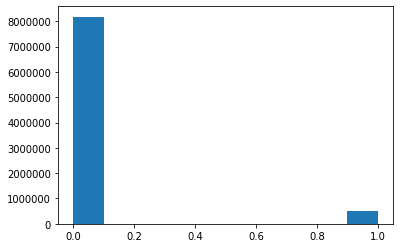

In [14]:
#target variable distribution
plt.hist(target)
plt.show()

In [15]:
vc = target.value_counts()
print(vc)
print('proportion of zeros {:.3f}%'.format(100 - (vc[1]/vc[0])*100))
print('proportion of ones {:.3f}%'.format((vc[1]/vc[0])*100))

0    8178304
1     520006
Name: is_click, dtype: int64
proportion of zeros 93.642%
proportion of ones 6.358%


## new columns for new df

In [16]:
#average smoothing

In [17]:
tcorr = pd.concat([new_train, target], axis = 1)

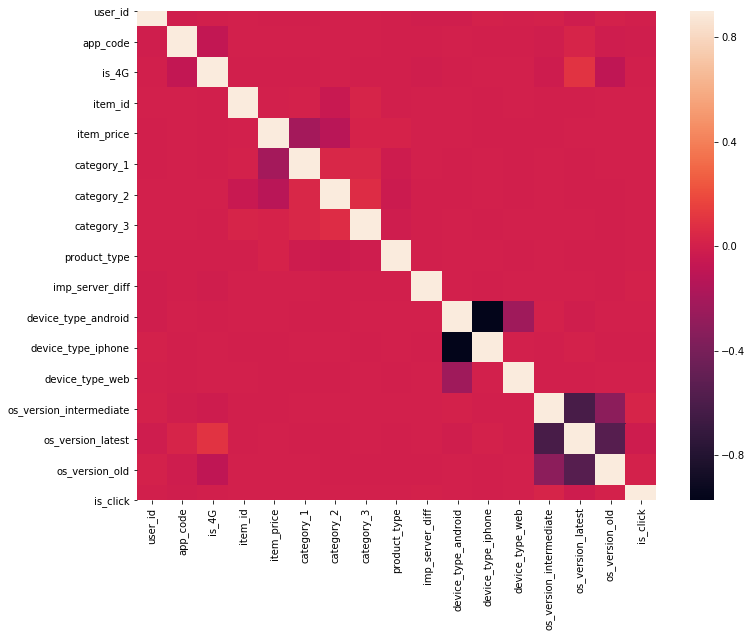

In [18]:
corrmat = tcorr.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, GradientBoostingRegressor)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

# Model creation

In [20]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(new_train, target, test_size = 0.3, random_state = 1234)

In [21]:
del new_train
del target
del tcorr
del train
del view
del items

In [22]:
print(X_test.shape)
X_train.shape

(2609493, 17)


(6088817, 17)

In [23]:
target_mean = y_train.mean()

In [24]:
train = pd.concat([X_train, y_train], axis = 1)
y_tr = train['is_click'].values
cols = ['user_id', 'item_id', 'category_1', 'category_2', 'category_3', 'app_code', 'product_type']

In [25]:
del X_train
del y_train

In [26]:
folds = KFold(5, shuffle = False)

for train_index, val_index in folds.split(train):

    X_tr, X_val = train.iloc[train_index], train.iloc[val_index]
    for col in cols:

        train.loc[train.index[val_index], col+' target_enc'] = X_val['user_id'].map(\
            X_tr.groupby(col)['is_click'].mean())
    
new_train = train.fillna(target_mean)

In [27]:
del train

In [28]:
print(new_train.shape)
new_train.head()

(6088817, 25)


impression_id  user_id  app_code  is_4G  item_id  \
5834379  75ac1e8ac2de975e8127c5bc617f4b0e    71683       283      0   106958   
1109234  cfad29d2e975510540d112caa4bd85f8    83766       127      0   126140   
4606214  2026dd4c3e6bbc6de46a98432db3a929    20942       386      1    34110   
4203208  1d9c75dde258f64a842e31ea888708d9    36938       386      0      425   
161374   ddf354219aac374f1d40b7e760ee5bb7    33499       207      1    42173   

         item_price  category_1  category_2  category_3  product_type  ...  \
5834379     1465.00       13.00       58.00      265.00       2652.00  ...   
1109234    10803.00        8.00       40.00       84.00       5036.00  ...   
4606214    57881.00        8.00       41.00       36.00       9445.00  ...   
4203208     1025.00        4.00       74.00      292.00       4524.00  ...   
161374      1728.00        1.00       12.00      301.00       7455.00  ...   

         os_version_latest  os_version_old  is_click  user_id target_enc  \
5834379                  0               0         0                0.25   
1109234                  1               0         1                0.22   
4606214                  1               0         0                0.00   
4203208                  1               0         0                0.00   
161374                   1               0         0                0.00   

         item_id target_enc  category_1 target_enc  category_2 target_enc  \
5834379                0.07                   0.06                   0.06   
1109234                0.00                   0.06                   0.06   
4606214                0.06                   0.06                   0.06   
4203208                0.07                   0.06                   0.06   
161374                 0.06                   0.06                   0.06   

         category_3 target_enc  app_code target_enc  product_type target_enc  
5834379                   0.06                 0.06                     0.06  
1109234                   0.06                 0.06                     0.06  
4606214                   0.06                 0.06                     0.06  
4203208                   0.06                 0.06                     0.06  
161374                    0.06                 0.06                     0.06  

[5 rows x 25 columns]

In [29]:
print(X_test.shape)
X_test.head()

(2609493, 17)


impression_id  user_id  app_code  is_4G  item_id  \
8245898  793e3394da2c00053e759b1948d76d11    44965       409      0    23356   
4469705  704f4913246227cae32af030e6a90280      928       190      0    88870   
7372182  96ac47a20d3bede54398d5af3a2c8b6d    72826       144      0   122118   
6728121  97828b9fe11184ca640835ecd080e142    21004       249      1    38231   
3211177  384471bca7a678fe3dc33db3042e6911    81864        32      1    53063   

         item_price  category_1  category_2  category_3  product_type  \
8245898     2304.00       11.00       51.00      181.00       8137.00   
4469705     1843.00        0.00       45.00       73.00       8838.00   
7372182     5945.00       10.00       63.00      220.00       3328.00   
6728121     1977.00       14.00       61.00      159.00       4426.00   
3211177    10758.00        9.00        3.00       48.00       1672.00   

         imp_server_diff  device_type_android  device_type_iphone  \
8245898                0                    1                   0   
4469705                0                    1                   0   
7372182                0                    1                   0   
6728121            41820                    1                   0   
3211177             4740                    1                   0   

         device_type_web  os_version_intermediate  os_version_latest  \
8245898                0                        0                  0   
4469705                0                        0                  1   
7372182                0                        1                  0   
6728121                0                        0                  1   
3211177                0                        1                  0   

         os_version_old  
8245898               1  
4469705               0  
7372182               0  
6728121               0  
3211177               0

In [30]:
X_train = new_train.drop('is_click', axis = 1)
y_train = new_train['is_click']

In [31]:
del new_train

In [32]:
X_train.drop('impression_id', axis = 1, inplace = True)
X_test.drop('impression_id', axis = 1, inplace = True)

/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
X_train.columns

Index(['user_id', 'app_code', 'is_4G', 'item_id', 'item_price', 'category_1',
       'category_2', 'category_3', 'product_type', 'imp_server_diff',
       'device_type_android', 'device_type_iphone', 'device_type_web',
       'os_version_intermediate', 'os_version_latest', 'os_version_old',
       'user_id target_enc', 'item_id target_enc', 'category_1 target_enc',
       'category_2 target_enc', 'category_3 target_enc', 'app_code target_enc',
       'product_type target_enc'],
      dtype='object')

In [35]:
print(X_train.shape)
assert list(X_train['item_id'].unique()) == list(X_test['item_id'].unique())

(6088817, 23)


AssertionError: 

In [37]:
print(X_train[['item_id', 'item_id target_enc']].shape)
iddd = X_train[['item_id', 'item_id target_enc']].drop_duplicates()
print(iddd.shape)
iddd.head(15)

(6088817, 2)
(583426, 2)


item_id  item_id target_enc
5834379   106958                0.07
1109234   126140                0.00
4606214    34110                0.06
4203208      425                0.07
161374     42173                0.06
8105573    15437                0.33
4745777     1741                0.10
5639269   116206                0.06
2286410    94926                0.00
3063373    23356                0.00
8556237    12208                0.00
4299577   106762                0.00
4192455     5158                0.00
234092    100648                0.00
2138627    62005                0.00

In [ ]:
item_id_dict = {k:None for k,v in zip(iddd['item_id'], iddd['item_id target_enc'])}
X_test['item_id'].replace(item_id_dict)

In [34]:
excols = ['user_id', 'app_code', 'item_id', 'item_price', 'category_1',
       'category_2', 'category_3', 'product_type', 'imp_server_diff']

In [35]:
def scale(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    df1 = scaler.transform(df)
    output = pd.DataFrame(columns = df.columns, data = df1, index = df.index)
    return output

In [36]:
xx_train = scale(X_train[excols])
xx_test = scale(X_test[excols])
X_train[excols] = xx_train[excols]
X_test[excols] = xx_test[excols]

/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [37]:
print(X_test.shape)
X_test.head()

(2609493, 16)


user_id  app_code  is_4G  item_id  item_price  category_1  \
8245898    -0.05      1.18      0    -1.12       -0.34        0.31   
4469705    -1.68     -0.46      0     0.59       -0.35       -1.78   
7372182     0.98     -0.80      0     1.46       -0.19        0.12   
6728121    -0.94     -0.02      1    -0.73       -0.35        0.89   
3211177     1.32     -1.64      1    -0.34        0.01       -0.07   

         category_2  category_3  product_type  imp_server_diff  \
8245898        0.55        0.11          0.95            -0.50   
4469705        0.28       -1.02          1.18            -0.50   
7372182        1.09        0.53         -0.64            -0.50   
6728121        1.00       -0.12         -0.28             1.26   
3211177       -1.63       -1.29         -1.19            -0.30   

         device_type_android  device_type_iphone  device_type_web  \
8245898                    1                   0                0   
4469705                    1                   0                0   
7372182                    1                   0                0   
6728121                    1                   0                0   
3211177                    1                   0                0   

         os_version_intermediate  os_version_latest  os_version_old  
8245898                        0                  0               1  
4469705                        0                  1               0  
7372182                        1                  0               0  
6728121                        0                  1               0  
3211177                        1                  0               0

In [38]:
del xx_train
del xx_test

In [39]:
X_train.head()

user_id  app_code  is_4G  item_id  item_price  category_1  \
5834379     0.94      0.24      0     1.06       -0.37        0.70   
1109234     1.39     -0.93      0     1.57        0.01       -0.26   
4606214    -0.94      1.01      1    -0.84        1.91       -0.26   
4203208    -0.35      1.01      0    -1.72       -0.39       -1.02   
161374     -0.48     -0.33      1    -0.63       -0.36       -1.59   

         category_2  category_3  product_type  imp_server_diff  ...  \
5834379        0.87        1.00         -0.87            -0.50  ...   
1109234        0.05       -0.91         -0.08             3.03  ...   
4606214        0.09       -1.41          1.38             0.51  ...   
4203208        1.60        1.29         -0.25            -0.50  ...   
161374        -1.22        1.38          0.73            -0.50  ...   

         os_version_intermediate  os_version_latest  os_version_old  \
5834379                        1                  0               0   
1109234                        0                  1               0   
4606214                        0                  1               0   
4203208                        0                  1               0   
161374                         0                  1               0   

         user_id target_enc  item_id target_enc  category_1 target_enc  \
5834379                0.25                0.07                   0.06   
1109234                0.22                0.00                   0.06   
4606214                0.00                0.06                   0.06   
4203208                0.00                0.07                   0.06   
161374                 0.00                0.06                   0.06   

         category_2 target_enc  category_3 target_enc  app_code target_enc  \
5834379                   0.06                   0.06                 0.06   
1109234                   0.06                   0.06                 0.06   
4606214                   0.06                   0.06                 0.06   
4203208                   0.06                   0.06                 0.06   
161374                    0.06                   0.06                 0.06   

         product_type target_enc  
5834379                     0.06  
1109234                     0.06  
4606214                     0.06  
4203208                     0.06  
161374                      0.06  

[5 rows x 23 columns]

In [40]:
print(X_train.shape)
y_train.value_counts()

(6088817, 23)


0    5725752
1     363065
Name: is_click, dtype: int64

In [41]:
train = pd.concat([X_train, y_train], axis = 1)

In [58]:
click = train.loc[train['is_click'] == 1]
non_click = train.loc[train['is_click'] == 0][:363065]

new_train = pd.concat([click, non_click])

In [59]:
print(click.shape)
print(non_click.shape)
new_train['is_click'].value_counts()

(363065, 24)
(363065, 24)


1    363065
0    363065
Name: is_click, dtype: int64

In [54]:
del X_train
del y_train
del click
del non_click

In [60]:
y_train = new_train['is_click']
X_train = new_train.drop('is_click', axis = 1)

In [51]:
X_test.shape

(2609493, 16)

In [57]:
from xgboost import XGBClassifier

In [58]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=600, max_depth=5,
                        min_child_weight=6, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=123)

In [59]:
xgb.fit(X_train, y_train)
preds_xgb = xgb.predict_proba(X_test)[:,1]
print(len(preds_xgb))
preds_xgb

ValueError: feature_names mismatch: ['user_id', 'app_code', 'is_4G', 'item_id', 'item_price', 'category_1', 'category_2', 'category_3', 'product_type', 'imp_server_diff', 'device_type_android', 'device_type_iphone', 'device_type_web', 'os_version_intermediate', 'os_version_latest', 'os_version_old', 'user_id target_enc', 'item_id target_enc', 'category_1 target_enc', 'category_2 target_enc', 'category_3 target_enc', 'app_code target_enc', 'product_type target_enc'] ['user_id', 'app_code', 'is_4G', 'item_id', 'item_price', 'category_1', 'category_2', 'category_3', 'product_type', 'imp_server_diff', 'device_type_android', 'device_type_iphone', 'device_type_web', 'os_version_intermediate', 'os_version_latest', 'os_version_old']
expected category_3 target_enc, app_code target_enc, product_type target_enc, item_id target_enc, category_1 target_enc, category_2 target_enc, user_id target_enc in input data

In [ ]:
preds_xgb_ex = preds_xgb

In [ ]:
def get_score_ex(preds, impression_test):
    fil = pd.concat([pd.Series(list(impression_test)).rename('impression_id'), 
                     pd.Series(preds).rename('is_click')], axis = 1)
    sup_fin = pd.merge(final_extest, fil, how = 'left', left_on = ['impression_id'], right_on = ['impression_id'])
    end = sup_fin.groupby(['impression_id'])['is_click_x','is_click_y'].max().reset_index()
    return roc_auc_score(end['is_click_x'], end['is_click_y'])

In [ ]:
get_score_ex(preds_xgb, ex_impression_test)

In [82]:
#lightgbm approach
import lightgbm as lgbm

/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [83]:
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.6
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }

In [85]:
dtrain = lgbm.Dataset(X_train, y_train)
bst = lgbm.train(params, dtrain, num_boost_round, verbose_eval=100)

In [86]:
preds_bst_ex = bst.predict(X_test)

In [87]:
get_score_ex(preds_bst_ex, ex_impression_test)

0.8151071540885675

In [88]:
stacked = np.column_stack([
            preds_bst_ex, preds_xgb_ex
        ])
super_preds_ex  = [np.mean(i) for i in stacked]

In [89]:
get_score_ex(super_preds_ex, ex_impression_test)

0.8219586950671076

## Model creation

In [17]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(new_train, target, test_size = 0.3, random_state = 42)

In [18]:
del new_train

In [19]:
final_test = pd.concat([X_test, y_test], axis = 1)[['impression_id', 'is_click']]
final_test.head()

impression_id  is_click
2967881  e1046da167e860b37c59183431698b8a         0
8653051  2fcb78c56584bd27e13ef8de2c4d2275         0
7187071  534c26605e7cb1c98b9aa898e2995d4e         0
521111   46d5c1db68612dea4b66fcd011a313e0         1
3084819  2d9b3265efaebfde79b545c2a1cab048         0

In [20]:
assert list(final_test['impression_id'].unique()) == list(X_test['impression_id'].unique())

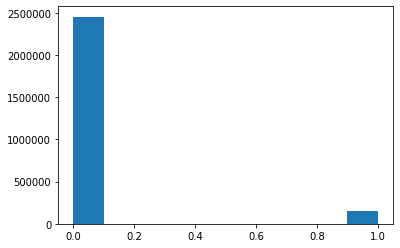

In [21]:
plt.hist(final_test['is_click'])
plt.show()

In [22]:
impression_train = X_train['impression_id']
impression_test = X_test['impression_id']
X_train.drop('impression_id', axis = 1, inplace = True)
X_test.drop('impression_id', axis = 1, inplace = True)

/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
def scale(df):
    scaler = MinMaxScaler()
    scaler = scaler.fit(df)
    df1 = scaler.transform(df)
    output = pd.DataFrame(columns = df.columns, data = df1, index = df.index)
    return output

In [24]:
X_train = scale(X_train)
X_test = scale(X_test)

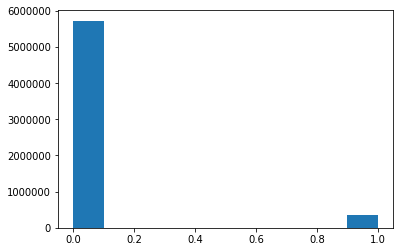

In [25]:
# y distribution
plt.hist(y_train)
plt.show()

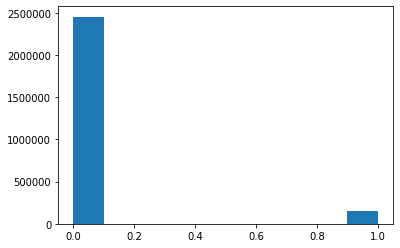

In [26]:
plt.hist(y_test)
plt.show()

In [27]:
print(X_test.shape)
X_test.head()

(2609493, 16)


user_id  app_code  is_4G  item_id  item_price  category_1  \
2967881     0.87      0.74   0.00     0.69        0.00        0.65   
8653051     0.29      0.40   0.00     0.67        0.01        0.35   
7187071     0.67      0.48   0.00     0.13        0.05        0.06   
521111      0.18      0.71   0.00     0.67        0.01        0.82   
3084819     0.87      0.39   1.00     0.19        0.00        1.00   

         category_2  category_3  product_type  imp_server_diff  \
2967881        0.65        0.96          0.29             0.00   
8653051        0.97        0.95          0.38             0.00   
7187071        0.53        0.30          0.95             0.00   
521111         0.78        0.95          0.85             0.00   
3084819        0.49        0.44          0.40             0.00   

         device_type_android  device_type_iphone  device_type_web  \
2967881                 1.00                0.00             0.00   
8653051                 1.00                0.00             0.00   
7187071                 1.00                0.00             0.00   
521111                  1.00                0.00             0.00   
3084819                 1.00                0.00             0.00   

         os_version_intermediate  os_version_latest  os_version_old  
2967881                     0.00               1.00            0.00  
8653051                     0.00               0.00            1.00  
7187071                     0.00               1.00            0.00  
521111                      1.00               0.00            0.00  
3084819                     0.00               1.00            0.00

# SECOND approach

In [28]:
## First approach imblearn
#from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
#from imblearn.under_sampling import RandomUnderSampler

In [29]:
#sm = ADASYN(random_state = 42, n_neighbors = 3)

In [30]:
#rus = RandomUnderSampler(random_state=0)
#X_res, y_res = rus.fit_resample(X_train, y_train)

In [31]:
print(X_train.shape)
y_train.value_counts()

(6088817, 16)


0    5724660
1     364157
Name: is_click, dtype: int64

In [32]:
train = pd.concat([X_train, y_train], axis = 1)

In [33]:
click = train.loc[train['is_click'] == 1]
non_click = train.loc[train['is_click'] == 0][:y_train.value_counts()[1]]

new_train = pd.concat([click, non_click])
#new_train.reset_index(inplace = True)

In [34]:
print(click.shape)
print(non_click.shape)
new_train['is_click'].value_counts()

(364157, 17)
(364157, 17)


1    364157
0    364157
Name: is_click, dtype: int64

In [35]:
y_train = new_train['is_click']
X_train = new_train.drop('is_click', axis = 1)

In [61]:
#get the roc_auc_score for a normal approach (untuned) Decision Tree with re-sampling
RF = RandomForestClassifier(n_estimators=300, max_depth=5, max_features = 'sqrt',
                                   min_samples_leaf=15, min_samples_split=8,random_state = 123)
RF.fit(X_train, y_train)
pred_rf = RF.predict_proba(X_test)[:,1]


In [62]:
roc_auc_score(y_test, pred_rf)

0.6566859454257746

In [ ]:
for i in [1,2,3]:

In [142]:
#tuned classifiers
logreg = LogisticRegression(random_state=123, penalty = 'l1', C = 4.0)
Ada = AdaBoostClassifier(learning_rate = 0.8, random_state = 123)
NB = GaussianNB()
Tree = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 15, random_state  =42, 
                              max_depth=5)
RF = RandomForestClassifier(n_estimators=300, max_depth=5, max_features = 'sqrt',
                                   min_samples_leaf=15, min_samples_split=8,random_state = 123)
GBoost = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1,
                                   max_depth=5, max_features = 'sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='deviance', random_state = 42)
GBoostr = GradientBoostingRegressor(random_state = 42)
#Lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [139]:
GBoost.fit(X_train, y_train)
pred_GBoost = GBoost.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred_GBoost)

0.7581552123038756

In [64]:
Ada.fit(X_train, y_train)
pred_Ada = Ada.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred_Ada)

0.6317361078735859

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_res, y_res)
pred_lg = logreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred_lg)

In [226]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=600, max_depth=5,
                        min_child_weight=6, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=123)

In [227]:
xgb.fit(X_train, y_train)
preds_xgb = xgb.predict_proba(X_test)[:,1]
print(len(preds_xgb))
preds_xgb

2609493


array([0.07300988, 0.20816202, 0.46747786, ..., 0.592014  , 0.59585357,
       0.66541946], dtype=float32)

In [229]:
get_score(preds_xgb, impression_test)

0.803612546196359

In [219]:
#lightgbm approach
import lightgbm as lgbm

In [220]:
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.6
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9
          }

In [221]:
dtrain = lgbm.Dataset(X_train, y_train)
bst = lgbm.train(params, dtrain, num_boost_round, verbose_eval=100)

In [222]:
preds = bst.predict(X_test)

In [223]:
get_score(preds, impression_test)

0.8041874963479732

In [52]:
class StackingModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # define clones to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Training
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #predictions
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    
    def predict_proba(self, X):
        predictions_proba = np.column_stack([
            model.predict_proba(X)[:,1] for model in self.models_
        ])
        return [np.mean(i) for i in predictions_proba]

In [50]:
stacked_models = StackingModels(models = (xgb, bst))
#stacked_models.fit(X_train, y_train)
#preds_sm = stacked_models.predict_proba(X_test)

NameError: name 'StackingModels' is not defined

In [230]:
stacked = np.column_stack([
            preds, preds_xgb
        ])
super_preds  = [np.mean(i) for i in stacked]

In [231]:
#stacked score predictions
get_score(super_preds, impression_test)

0.8137935946193905

In [213]:
# ensemble
ensemble = pd.Series(super_preds)*0.50  + pd.Series(preds_xgb)*.30 + pd.Series(pred_GBoost)*0.20

In [214]:
get_score(ensemble, impression_test)

0.803227008984436

## stacking II

In [189]:
class StackingAveragedModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
    def predict_proba(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict_proba(meta_features)

In [190]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

In [191]:
X_train.head()

user_id  app_code  is_4G  item_id  item_price  category_1  category_2  \
0     0.53      0.24   0.00     0.25        0.00        0.76        0.73   
1     0.56      0.36   0.00     0.25        0.02        0.06        0.81   
2     0.03      0.40   1.00     0.70        0.01        0.06        0.09   
3     0.01      0.28   0.00     0.63        0.00        0.76        0.73   
4     0.96      0.01   0.00     0.92        0.00        0.76        0.85   

   category_3  product_type  imp_server_diff  device_type_android  \
0        0.30          0.13             0.00                 1.00   
1        0.77          0.27             0.00                 1.00   
2        0.88          0.15             0.31                 1.00   
3        0.51          0.81             0.83                 1.00   
4        0.50          0.27             0.00                 1.00   

   device_type_iphone  device_type_web  os_version_intermediate  \
0                0.00             0.00                     0.00   
1                0.00             0.00                     0.00   
2                0.00             0.00                     1.00   
3                0.00             0.00                     0.00   
4                0.00             0.00                     0.00   

   os_version_latest  os_version_old  
0               1.00            0.00  
1               0.00            1.00  
2               0.00            0.00  
3               1.00            0.00  
4               1.00            0.00

In [192]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: is_click, dtype: int64

In [193]:
stacked_averaged_models = StackingAveragedModels(base_models = (Tree, logreg, NB),
                                                 meta_model = GBoost)
stacked_averaged_models.fit(X_train, y_train)

/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

StackingAveragedModels(base_models=(DecisionTreeClassifier(class_weight=None,
                                                           criterion='gini',
                                                           max_depth=5,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=15,
                                                           min_samples_split=10,
                                                           min_weight_fraction_leaf=0.0,
                                                           presort=False,
                                                           random_state=42,
                                             

In [194]:
stacked_preds = stacked_averaged_models.predict_proba(X_test)[:,1]

In [195]:
stacked_preds

array([0.20796446, 0.22238341, 0.5570435 , ..., 0.5570435 , 0.5570435 ,
       0.59280535])

In [196]:
get_score(stacked_preds, impression_test)

0.6266494282155315

In [202]:
# ensemble
ensemble = pd.Series(super_preds)*0.40  + pd.Series(preds)*.40 + pd.Series(preds_xgb)*0.20

In [203]:
get_score(ensemble, impression_test)

0.809580945213697

# Test set ex

In [104]:
new_test = create_dataset(view, items, dataset = test, test_set = True)
new_test.head()

impression_id  user_id  app_code  is_4G  item_id  \
0  a9e7126a585a69a32bc7414e9d0c0ada    44754       127      1   128995   
1  caac14a5bf2ba283db7708bb34855760    29656        44      0    55912   
2  caac14a5bf2ba283db7708bb34855760    29656        44      0   118458   
3  caac14a5bf2ba283db7708bb34855760    29656        44      0     9201   
4  caac14a5bf2ba283db7708bb34855760    29656        44      0   126140   

   item_price  category_1  category_2  category_3  product_type  \
0    23424.00        1.00       42.00      220.00       1617.00   
1     1529.00        9.00       44.00      114.00       9857.00   
2    35020.00        1.00       42.00      157.00       8994.00   
3     2048.00        9.00        9.00      244.00       1077.00   
4    10803.00        8.00       40.00       84.00       5036.00   

   imp_server_diff  device_type_android  device_type_iphone  device_type_web  \
0                0                    1                   0                0   
1                0                    1                   0                0   
2                0                    1                   0                0   
3                0                    1                   0                0   
4                0                    1                   0                0   

   os_version_intermediate  os_version_latest  os_version_old  
0                        0                  1               0  
1                        0                  1               0  
2                        0                  1               0  
3                        0                  1               0  
4                        0                  1               0

In [105]:
impression_ex = new_test['impression_id']
new_test_ex = new_test.drop('impression_id', axis = 1)

In [106]:
ex_test = new_test_ex

In [100]:
ex_test = pd.concat([new_test_ex, target], axis = 1)
ex_test.head()

user_id  app_code  is_4G   item_id  item_price  category_1  category_2  \
0 44754.00    127.00   1.00 128995.00    23424.00        1.00       42.00   
1 29656.00     44.00   0.00  55912.00     1529.00        9.00       44.00   
2 29656.00     44.00   0.00 118458.00    35020.00        1.00       42.00   
3 29656.00     44.00   0.00   9201.00     2048.00        9.00        9.00   
4 29656.00     44.00   0.00 126140.00    10803.00        8.00       40.00   

   category_3  product_type  imp_server_diff  device_type_android  \
0      220.00       1617.00             0.00                 1.00   
1      114.00       9857.00             0.00                 1.00   
2      157.00       8994.00             0.00                 1.00   
3      244.00       1077.00             0.00                 1.00   
4       84.00       5036.00             0.00                 1.00   

   device_type_iphone  device_type_web  os_version_intermediate  \
0                0.00             0.00                     0.00   
1                0.00             0.00                     0.00   
2                0.00             0.00                     0.00   
3                0.00             0.00                     0.00   
4                0.00             0.00                     0.00   

   os_version_latest  os_version_old  is_click  
0               1.00            0.00      0.00  
1               1.00            0.00      1.00  
2               1.00            0.00      1.00  
3               1.00            0.00      1.00  
4               1.00            0.00      1.00

In [101]:
new_item_id = calc_smooth_mean(ex_test, by = 'item_id', on = 'is_click', m = 10)
new_cat1 = calc_smooth_mean(ex_test, by = 'category_1', on = 'is_click', m = 10)
new_cat2 = calc_smooth_mean(ex_test, by = 'category_2', on = 'is_click', m = 10)
new_cat3 = calc_smooth_mean(ex_test, by = 'category_3', on = 'is_click', m = 10)
new_appcode = calc_smooth_mean(ex_test, by = 'app_code', on = 'is_click', m = 10)
new_prodtype = calc_smooth_mean(ex_test, by = 'product_type', on = 'is_click', m = 10)
ex_test = ex_test.assign(app_code = new_appcode, item_id = new_item_id, category_1 = new_cat1, 
         category_2 = new_cat2, category_3 = new_cat3, product_type = new_prodtype)
ex_test.head()

user_id  app_code  is_4G  item_id  item_price  category_1  category_2  \
0 44754.00      0.06   1.00     0.06    23424.00        0.06        0.06   
1 29656.00      0.07   0.00     0.06     1529.00        0.06        0.06   
2 29656.00      0.07   0.00     0.07    35020.00        0.06        0.06   
3 29656.00      0.07   0.00     0.06     2048.00        0.06        0.06   
4 29656.00      0.07   0.00     0.06    10803.00        0.06        0.06   

   category_3  product_type  imp_server_diff  device_type_android  \
0        0.06          0.06             0.00                 1.00   
1        0.06          0.06             0.00                 1.00   
2        0.06          0.07             0.00                 1.00   
3        0.06          0.06             0.00                 1.00   
4        0.06          0.06             0.00                 1.00   

   device_type_iphone  device_type_web  os_version_intermediate  \
0                0.00             0.00                     0.00   
1                0.00             0.00                     0.00   
2                0.00             0.00                     0.00   
3                0.00             0.00                     0.00   
4                0.00             0.00                     0.00   

   os_version_latest  os_version_old  is_click  
0               1.00            0.00      0.00  
1               1.00            0.00      1.00  
2               1.00            0.00      1.00  
3               1.00            0.00      1.00  
4               1.00            0.00      1.00

In [110]:
excols = ['user_id', 'item_price', 'imp_server_diff', 'item_id', 'category_1', 'category_2', 'category_3', 'app_code',
         'product_type']
xx_ftest = scale(ex_test[excols])
ex_test[excols] = xx_ftest[excols]

In [111]:
ex_test.head(15)

user_id  app_code  is_4G  item_id  item_price  category_1  category_2  \
0     -0.06     -0.98      1     1.65        0.52       -1.59        0.14   
1     -0.62     -1.60      0    -0.27       -0.37       -0.07        0.23   
2     -0.62     -1.60      0     1.37        0.99       -1.59        0.14   
3     -0.62     -1.60      0    -1.49       -0.35       -0.07       -1.36   
4     -0.62     -1.60      0     1.57        0.01       -0.26        0.05   
5     -0.62     -1.60      0     0.80       -0.36        0.51        0.82   
6     -0.62     -1.60      0     1.08       -0.39       -0.26       -0.81   
7     -0.62     -1.60      0    -1.32       -0.41        0.32        0.55   
8     -0.62     -1.60      0    -1.16       -0.04        1.27       -1.00   
9     -0.62     -1.60      0    -0.07       -0.25        0.12        1.10   
10    -0.62     -1.60      0     0.64       -0.24       -1.59       -0.50   
11    -0.62     -1.60      0     1.59       -0.38       -0.45        0.69   
12    -0.62     -1.60      0    -1.51        0.31       -1.59        0.14   
13    -0.62     -1.60      0     0.06       -0.36        0.32       -0.18   
14    -0.62     -1.60      0     0.24       -0.42        1.08        0.37   

    category_3  product_type  imp_server_diff  device_type_android  \
0         0.53         -1.20             0.00                    1   
1        -0.59          1.52             0.00                    1   
2        -0.14          1.24             0.00                    1   
3         0.78         -1.38             0.00                    1   
4        -0.91         -0.07             0.00                    1   
5         0.01          0.66             0.00                    1   
6        -0.70         -0.77             0.00                    1   
7        -1.64          1.35             0.00                    1   
8         1.08          1.59             0.00                    1   
9         1.40         -0.18             0.00                    1   
10        1.75          0.79             0.00                    1   
11        1.06          1.16             0.00                    1   
12       -0.14         -1.20             0.00                    1   
13       -0.23          1.05             0.00                    1   
14       -0.85         -0.79             0.00                    1   

    device_type_iphone  device_type_web  os_version_intermediate  \
0                    0                0                        0   
1                    0                0                        0   
2                    0                0                        0   
3                    0                0                        0   
4                    0                0                        0   
5                    0                0                        0   
6                    0                0                        0   
7                    0                0                        0   
8                    0                0                        0   
9                    0                0                        0   
10                   0                0                        0   
11                   0                0                        0   
12                   0                0                        0   
13                   0                0                        0   
14                   0                0                        0   

    os_version_latest  os_version_old  
0                   1               0  
1                   1               0  
2                   1               0  
3                   1               0  
4                   1               0  
5                   1               0  
6                   1               0  
7                   1               0  
8                   1               0  
9                   1               0  
10                  1               0  
11                  1               0  
12                  1               0  
1

# Test set

In [90]:
new_test = create_dataset(view, items, dataset = test, test_set = True)
new_test.head()

impression_id  user_id  app_code  is_4G  item_id  \
0  a9e7126a585a69a32bc7414e9d0c0ada    44754       127      1   128995   
1  caac14a5bf2ba283db7708bb34855760    29656        44      0    55912   
2  caac14a5bf2ba283db7708bb34855760    29656        44      0   118458   
3  caac14a5bf2ba283db7708bb34855760    29656        44      0     9201   
4  caac14a5bf2ba283db7708bb34855760    29656        44      0   126140   

   item_price  category_1  category_2  category_3  product_type  \
0    23424.00        1.00       42.00      220.00       1617.00   
1     1529.00        9.00       44.00      114.00       9857.00   
2    35020.00        1.00       42.00      157.00       8994.00   
3     2048.00        9.00        9.00      244.00       1077.00   
4    10803.00        8.00       40.00       84.00       5036.00   

   imp_server_diff  device_type_android  device_type_iphone  device_type_web  \
0                0                    1                   0                0   
1                0                    1                   0                0   
2                0                    1                   0                0   
3                0                    1                   0                0   
4                0                    1                   0                0   

   os_version_intermediate  os_version_latest  os_version_old  
0                        0                  1               0  
1                        0                  1               0  
2                        0                  1               0  
3                        0                  1               0  
4                        0                  1               0

In [91]:
new_test.shape

(3055644, 17)

In [92]:
impression = new_test['impression_id']
new_test = new_test.drop('impression_id', axis = 1)

In [93]:
assert list(impression.unique()) == list(test['impression_id'].unique())

In [94]:
#function for getting classifiers auc
def fit_pred_auc(model):
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, pred)
    return auc

#function for getting linear models auc
n_folds = 5
def auc_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    auc= cross_val_score(model, X_train.values, y_train, scoring="roc_auc", cv = kf)
    return(auc)

In [95]:
new_test.isnull().sum()

user_id                       0
app_code                      0
is_4G                         0
item_id                       0
item_price                 1974
category_1                 1974
category_2                 1974
category_3                 1974
product_type               1974
imp_server_diff               0
device_type_android           0
device_type_iphone            0
device_type_web               0
os_version_intermediate       0
os_version_latest             0
os_version_old                0
dtype: int64

In [96]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imp.fit(new_test)
test_dff = imputer.transform(new_test)
new_test_imp = pd.DataFrame(columns = new_test.columns, data = test_dff, index = new_test.index)

/Users/alejandrogalindo/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [239]:
new_test_scale = scale(new_test_imp)

In [240]:
new_test_scale.head()

user_id  app_code  is_4G  item_id  item_price  category_1  category_2  \
0     0.48      0.24   1.00     0.97        0.02        0.06        0.53   
1     0.32      0.08   0.00     0.42        0.00        0.53        0.56   
2     0.32      0.08   0.00     0.89        0.03        0.06        0.53   
3     0.32      0.08   0.00     0.07        0.00        0.53        0.11   
4     0.32      0.08   0.00     0.95        0.01        0.47        0.51   

   category_3  product_type  imp_server_diff  device_type_android  \
0        0.65          0.15             0.00                 1.00   
1        0.33          0.93             0.00                 1.00   
2        0.46          0.85             0.00                 1.00   
3        0.72          0.10             0.00                 1.00   
4        0.25          0.48             0.00                 1.00   

   device_type_iphone  device_type_web  os_version_intermediate  \
0                0.00             0.00                     0.00   
1                0.00             0.00                     0.00   
2                0.00             0.00                     0.00   
3                0.00             0.00                     0.00   
4                0.00             0.00                     0.00   

   os_version_latest  os_version_old  
0               1.00            0.00  
1               1.00            0.00  
2               1.00            0.00  
3               1.00            0.00  
4               1.00            0.00

In [241]:
new_test_imp.isnull().sum()

user_id                    0
app_code                   0
is_4G                      0
item_id                    0
item_price                 0
category_1                 0
category_2                 0
category_3                 0
product_type               0
imp_server_diff            0
device_type_android        0
device_type_iphone         0
device_type_web            0
os_version_intermediate    0
os_version_latest          0
os_version_old             0
dtype: int64

In [242]:
preds_bst = bst.predict(new_test_scale)
#preds = preds[:,1]

In [243]:
preds_xgb = xgb.predict_proba(new_test_scale)[:,1]

In [244]:
stacked = np.column_stack([
            preds_bst, preds_xgb
        ])
super_preds  = [np.mean(i) for i in stacked]
get_score(super_preds, impression_test)

0.5482264453873553

In [78]:
len(super_preds)

3055644

In [82]:
pd.Series(super_preds).isnull().sum()

0

In [83]:
len(impression)

3055644

In [245]:
sub = pd.concat([pd.Series(impression), pd.Series(super_preds).rename('is_click')], axis = 1)
sub = sub.groupby(['impression_id'])['is_click'].max().reset_index()
print(sub.shape)
sub.head()

(90675, 2)


impression_id  is_click
0  000109e6bf54b3b20e8547b6026bc355      0.40
1  0001c82eb924a3dca30593bf7d8f2227      0.12
2  00038787e666dbf59f419128a0ee3a66      0.21
3  00044057f135cc6526be752ad83115f6      0.67
4  0004bdb4af3099a24adffc7ff08803e7      0.16

In [246]:
sub.isnull().sum()

impression_id    0
is_click         0
dtype: int64

In [247]:
sub.to_csv('submission0.csv')

In [248]:
list(impression.unique())

['a9e7126a585a69a32bc7414e9d0c0ada',
 'caac14a5bf2ba283db7708bb34855760',
 '13f10ba306a19ce7bec2f3cae507b698',
 '39c4b4dc0e9701b55a0a4f072008fb3f',
 'bf5a572cca75f5fc67f4b14e58b11d70',
 'ca09514449e304fee91456fb0918667a',
 'b8b35cb0ae1719aa9f0ba7a9f3785687',
 '33502d1e85818b9b3414c8c006c34e07',
 '5314e09fb680c56b58eb5a3b5b7bce0c',
 'e1a8a26385f49a5a7e04d34a5823bff3',
 '0a2388627db42a15565ad1e47daa6025',
 '382193e62cbf57e49abf441063019542',
 '27f17fd775ec9bf0e1abffe2c1206434',
 '41fe27ce246bd9772e005da454d6b0e1',
 '85b73c10a8fba7060054d48d542279d6',
 'e22fabe59530363b97507c7294bca996',
 'e48379e1edcf90e9cfc6bcac30d84151',
 'f145cff1f3e70e0f6556911504369a3d',
 '8d680e215a2bf3c38d3663904e80561b',
 '74bfc8abbd41a8e4659d1873a9c495ab',
 'b521ddda4c58202868680bd09028cf7d',
 '9ef2e3d2a0e11a0da4adc7d50f403e12',
 '7ff1cf3d2a03dab68c209ae9efd78849',
 'a79e11fda1df1d3d15e25a678b4f64f3',
 'b28d65100de9473e159832d8fbfc08ce',
 '71c007e973f01320af45a0a8a118815c',
 '0d3fd12d7d3d1c57e4834223a92c85e0',
 

In [354]:
test.shape

(90675, 6)

In [355]:
sub.tail()

impression_id  is_click
90670  fffb7471fecd6f11670e97e1699feb8f      0.58
90671  fffdef83c6959d9737880153fc466e45      0.11
90672  fffe85137b9a34cd129f24458dd1ea38      0.54
90673  ffff1b67c9bf77f1dd4df612f6f3911d      0.11
90674  ffff31b8d1dd1486a7fe6914761aa655      0.30

In [173]:
submission.tail()

impression_id  is_click
90670  14e40cf9f6b71d972a8cbf6836a230c4         0
90671  e473cad398d5de9cb5be83d9a9ca0b97         0
90672  e99817afa73431282bb3ddb6eaff1ff7         0
90673  70ace7a2908312f7e24a427afefb2a55         0
90674  539145030fb3600d26d6a64130310035         0

In [176]:
for i in sub['impression_id']:
    if i not in test['impression_id']:
        print(i)

000109e6bf54b3b20e8547b6026bc355
0001c82eb924a3dca30593bf7d8f2227
00038787e666dbf59f419128a0ee3a66
00044057f135cc6526be752ad83115f6
0004bdb4af3099a24adffc7ff08803e7
0006768c0a91060c1cef5d45fa15addb
000739e6bc947cf2ba6e6d2d16bfc046
00074ef1e38588f97e05728525be5c3f
000836ac15f2f993ed30500a4e7cbeb0
00087f0d21618b2bc9aba0ebb402c6ef
0009760ab741468dd96e690049c4e53b
0009d8b97e99bda6832334fc16d17c81
000a149099a55a6e74fd253ab3f5709d
000a83897e7fb0d52bad388c751381b2
000cdc3702cf96b05e72a68eece67dcc
000ce6cfab1820e2ec3d8b56dea07ff4
000df2a7f1dbfc5ed7b8746b3036f465
000e46450a099cd2ccdf44a30d987ed1
000ebb512c58ebd80e6111b713e225df
000f564b70317e6cf3d4df9a611059f0
00100f40cbb42f4eebc8433493c4a004
0010fe877530dba5a832ba43ce27cdcc
0011cf041056c7eba3796dc4103a86b1
0013208c6b0b9a161dfee89a318568ec
00134edffcc1456df385d5e91b309e63
0014ccd0cb6a38c9e36a86bd4376be46
00172e7fab53628d8b2d455458a1a7f3
0017ac521e5d805c9ee93798173f318f
0017da7b67c1bd6d668761686f2b5d9b
0018370def1babc56a041019e784e65f
001ad3d313

0746395fc86bbc747260306f0fbda64c
0746d0395591705501f75f8532498fd9
07476d21430dbeb32acbf8520fcb7d2c
07477e42e8b9950e235f2435796ac0fa
07482ba932e30e8426c211faa538a7d3
074994a9f375b9dc1d6e16cdf643175e
0749aa354c4b2f45b33d6fe3c4a4e9a9
0749af4ab87b06634299710fc63c5387
074add356f887527afce82fb2f764581
074b264d79953b4ec3e964dcd7dcd409
074bf84144d06560aa92fc65dafdc986
074c2beb0179a7b7c16b787e355937b9
074caad382646166faf73b477a0cd4a3
074deb45c5f8648a41b1b0ed46a7c49b
074f617a6b6a895539aa4d541c522953
07508323af5c0eefd2504f6723abe776
0751a2260aca32a7c2daed9270c5ebb7
0752928bd25afda76d4d54ee702e80d4
0752f6454e4f942fbf7662c61dd5e455
07541326504781d2a90fb401c3ccb540
07564a15701839b5c1dcc042505bb767
07574dd4ded0a45f019f4496288185ab
0757e47c6d23ade81b0fd4e41ba2f47d
0757e4fe654712e11d591c41fb9c08de
07581e3ee4f1cdc16b8252420bf75ebe
075835fdf15535d49d800382bdd432a9
075836418315a400169cd03a60048f7f
0758ef21b570d1074396fe9e69146b83
075917ddf36e7b062744691bfad5c241
075a4ca1c8dd16acca1dd36ac238f719
075b2964f5

0ea9ba749c5d6dfcdfde24e7b1f1e915
0ea9d8e0854e3d5ec9d5e70d7ac0e343
0eaa1c79a5621703b4af671cb6a06f60
0eaa7f785cbda0368a9c29c6c7220133
0eab251824a83f1bb70546bcf79670aa
0eabf759536dc6ee2c51966eb1d7149c
0eac22da28227c9868dc56ec303b68dd
0eb05fb7a098238b875c530d10b2c929
0eb09e31d820ba259aaf6b3a40915bef
0eb16d3f4aaab7d782c242e2842cb8fa
0eb3885482a26378cd709cad094c4303
0eb549bc03be9a4adb57dfca19ba1de0
0eb5ca4f5fd856142c8adc945f4c92ec
0eb63dddf32d4308641b453a94933cfa
0eb77b5e6139792406c685235d37e090
0eb97ccbabab030f2325c57fd42d5552
0ebb84917c417a6c724d6324cd0834c0
0ebcaff284573eced9beb87aedc5df98
0ebdb479984cecf4eea3f289dba461c3
0ebf7b6cf6e9f299726b0b2bea8c30f2
0ec06413dbfaff35e422e89c770a9fba
0ec09a0c2340846bf046b47badc5c449
0ec105a7fa0a1787bacd750ba69bf271
0ec10d5e3ed3720a2d578417a894cf49
0ec12f60c1c6fa9e322989f919d92dee
0ec1409128e589658efc924e7a7ce0a6
0ec19bac435cd0ab3fcd2160491b0c7b
0ec31f09d3b7716055eba451abca0840
0ec3de8efeec71585da77082c04ca482
0ec45d93566a271714ef335414e3085d
0ec57c7127

16d61d79658c876049bc69ed94c3b564
16d79002ba9ef9a6cc882dd4d98175b6
16d7cabe363e0c07748325e2993fc980
16d8898d95934ae7fd0c826c7ce99602
16d96e67f77518b802657e0f8d16c1e3
16d99ce603199eba11a1b8813c0f08c1
16d9b6424678086773c9c92b029a5f51
16d9d42dcab0637105a66fe8b2d0f60f
16da6490c7a3a68a56e34e823994a5b7
16dc9fbc143217b6b0d30b3b89c6e4d1
16dd2568a57851b0634464e1cf116810
16ddc0b7c41f472940963513a656e95b
16dea5da47c09f8abb77407d50075ec9
16e106109782a87adfb879ee11fce591
16e11d6f145d756b08a46bb9887d57da
16e1b1f53957ae6da7b78eda3023c931
16e22bf771df6e8e925e2709e4b4bb95
16e34a187dbdfbc21166faeeed954687
16e3a782fe8923d1975af81f84f4c7ef
16e4084ae742d468ff9e18481ebc02cd
16e41a0c7ed817b691e1895c0a7cef2a
16e4c9e0b649908103b4c9b6835669d6
16e50881aefa5c7281443d2f0802a503
16e55c2b5ca646773d10ef5974058e9e
16e5b4126ac8b44750e16d89b6411889
16e6f92e89a5e9ca69124a20783cfaf5
16e6fc3b67f5f3d382d35fc884262c1f
16e902b9423b3c62c128be3f4fb8f612
16ea73d4eef4388e90fd188b5349c324
16ea7d99a4ee44d6c824740e3e08399e
16ec02ddd5

1dfbc054ec5acdbf9aa7574694730605
1dfd5ad11fc9062cc61bb70e121afb58
1dfe4f0ca2309b47920b4366ea6988a3
1dff43e56fc4180f265c8dcc9b6ffc73
1dff7eab36808af12ea4d4c1c1af739c
1e0029089769a7117203fc52972d4e16
1e01b6910c978b0a518e61ae6a5e6c16
1e04ebb3c644ceda8a092982f515f75a
1e055f4a5fb8cd44dc170519dd7c767a
1e05df8c044c4aea507b6660c765cb4f
1e062bcb52e0085fca2ea8e4e7952e79
1e0657877ee6cc877cbc7f458b4beca0
1e07004b6d55233f9cd40e0e4a662e8b
1e0738e7823101eca28ee7bd849ced4b
1e07a2e2476324b196814dd325e24a8e
1e0872bb2f1b2b3ec22d72ab8e35e291
1e0ab299d64b7978f0f3198f290b4dda
1e0b2841e447939fc2432ac4f1b041e5
1e0b304a9275e1e1579cceab9c476c55
1e0c48427c6f1de1263018d0c10e21fe
1e0da4a978247cbb7fca843f50e31f95
1e0e255c95ad321e677b613fcd34249a
1e0e77d64b6d4f1ec1a282ae9531e28c
1e0f380eb0efd423b9756c05404246fc
1e0f48e8ea398efe0d6e277d2b779e5f
1e1007f0de187b64ceb1e751e94e3e4c
1e108e4743f910a49a28dcb4dc6e13ad
1e11216453b71ed19f50b291aa8781a7
1e1136f3c0dcd528010456a334dd101c
1e118732ee37335138597bd64c6d325e
1e125267ae

25b0d7d49036593a73484b1d7fb326dc
25b14f935188733a568170b259366892
25b196b2438f8c9905f48b74d9d6ea84
25b1d2bb5f664d075b4ab3548e028876
25b34c70a46d3e4403efcc536dd3319d
25b457a38aa0c20e65cd1df9e63443dc
25b4596f3bbc821c1507d6916aafd7d4
25b5c7ce501ccff6eda3bf0d239ba0f7
25b6003a353effc66fc030ed5ba26c30
25b630936a5595c9c3678e886d8efbba
25b69f7816be5ac6bb7fc87a1b3fc4e8
25b91ccb04acf0cc51334741955ca887
25b9f446383739ebce91b8bef87ce9a8
25ba9718f3fe00ad43528e5d863e0190
25bb39325e8b3f09918a693b7c45bed7
25bc2f10ae5a3fecd276b6c32859adb6
25bc311346732f933ab8454019891ddb
25bc5133cf9d163e183b048adbd40dee
25bc61172f0e4ddee0f7df85bf6eee40
25bd992f8be51cfb6d8c1d2e11b134c9
25bdc77cad047a929a76d1d8fb544de4
25be486fe930b8b3e795e5a9394b6f43
25be59bdb8d6d6829ca33840b2b5b947
25bea4c152e2f1cda6104efc0d2e3964
25bf8a8abd95f71da5ee2f95005d82be
25bf92659a709abbc2932c880c317feb
25c3d4d524233bacb3f77759cbf7cd54
25c4adff3c03dccc2065bb6197367c75
25c4df6b082e9b9dbd16eb567b30c62a
25c6c17d5c0b0ed67fdfb91b7bde57c3
25c6edbcee

2dfa9121b459312eb5c71e117f2d5e82
2dfae9f876b738f8bb49f79c077fa1c4
2dfb333b3dae7e6806f587b590612d60
2dfb5f187120b3db4f0ad2aed22fd2e9
2dfbb796a7e12c59d16a966453e32fed
2dfbef376c947492241907ca1948b607
2dfca69652cc4d5472a5fe9f973fbf80
2dfdeb78b880d7b16115b15efc2fcabe
2dfe3cc2d86862c0ccbcd5ae243a334d
2dfeffaf3fae3c44111770e9df2f9074
2dffc5078599338f3f7adf2f0b9879b4
2dffe9d6d1ab51c8f87a1545cba41d33
2e006c8c3c330cd8c465d678ce9ef70e
2e013eef0fa53e5beb903ce1dea8b234
2e0175681718517be00329e984710fde
2e0195587fbf8dfca0b059f0d81eb6d0
2e01cc644bebc89e24333190d577abed
2e022f625a0b25f13c68c0a6cb613d96
2e0231109982c4a7b034cbeec2d481d2
2e024d71a5539f55ec717696f89ad444
2e02822bcee3334c7e09567c36788c51
2e02a0ecd0489fd25090bb40edba1068
2e03cfd37a1fbb09c97111493ff24184
2e0402af40d0d96004ab6c941394fe21
2e040f08fd397f7eb5c5531020316893
2e0449f66fe01e4cabd190ce79e99bcd
2e04f9da2e91d17ae5e7528ad76469d1
2e0520c40a00a99f2ad35e5378b52a96
2e052819178c4cb0f405321307c3bbe8
2e05a3ba1114df4c59e20558617c0363
2e05c66a16

3521f3c0acbfa4fc9408fcff966b0d72
352368f3c9a02e312a7a5c169050f7bb
3523a4d2c5ffdb694b46dd6b2bf19e36
3523b14bbaac424d76561dc27949a8a0
35255e61109334dfa3553ccedf0185b5
3526d99f3ed38c69c0b35f693a9547c8
352702300841588eeddcf9e7db771570
3527d40b52298ed3354806edda79c6ac
3529c00d9f86a4a4a217a62e37a48084
3529e194da4e8de6062b0e64f50b522b
352a913aa042287a7f2d787ed6afb566
352becfab9a13d08bb2b7f654b0f8bf4
352cf4b2e6b261c02c15ed8e89fa36d4
352e9c39c400fa714cbc55624dbc9aeb
352ea32ece618ba5e02b7bd5a42eecb1
352edb03b37278001ab92ec94492dd68
352f2553927bffa546166cc7c6e19c37
352fb8a62db4e37e16b221fb4cefd635
352ff48b47d0f5cdb78055db9e55a806
352ffe31682891b8f1b1236ec75e75af
35302de2ccf90cc1a6bdc8991e841d4c
35304a684af90acda87877a64234f3d0
3530ba7ebe92676cb8c26d380f66dc53
35314b0fa2dced1e0acc3dce3dcdf705
35315b827e53e568ecfe3d20a6577466
3531d196e9232f12412cf6732791c9f9
35321fc49000cf5b76b4e7f73586006f
3533bb0349e2279faffbbb9318c3f7dc
3534145355d7a565533df39642e73c31
353459222043e85ff41641c2bf7a32d3
353592715b

3e0f2e480602b179d604e1dbdc86d66b
3e0f3b76bfe286c7c25a292742dbcdc5
3e0f3c0396462c5a2763360c4fb0f69e
3e0f67e3151aae5da85fbf6a4cffbf43
3e108c2885e860ac728dd95c5e0d2473
3e11cdaaf869e22c7d492802e96b0c06
3e1208dd5c7b6ccfcc451dffee4334e4
3e122758a4799103e46a6e36a8dcb5ed
3e13de9e13a531639cf21e4353e656ec
3e14478c2ca9c1428a248b8ebef3755f
3e14c23184468736f7cda6d16054e7a3
3e14de2a5fe1a1a3dd53ca8434a9f534
3e15b4d0851522280bafae546e6f1d33
3e185f82c5f5ce43a3b7be273f908026
3e19b5306c207df99899cdd75e9533e3
3e19c7dbe4b7866f5bc71ecf21705246
3e1a50bf3e0e8a56094669188bb7c2e1
3e1d5cadcc06228554a85202b9c1c048
3e1ed23ffcc54214003eb389d32b87b9
3e1fb0cab594ea47d019d24d0016c8cf
3e2041fffe9ac07ba9efe9b21b20f08b
3e21706617b716c33f804f67975375a8
3e218f3803b08ff8f92676636de1cf7c
3e228111324783eeeb0091cc491c5fac
3e2302e2e960add20c4de01a1d4982fa
3e23497c16c4cc6e6fc10eaf72f911b8
3e24049d60e6c7ac507904c5f9fa53df
3e26c02b5bfddb03aeb8051a65a57eda
3e2721d961a9cb43ee5d0ae99d9084e4
3e29911483cdab47fc47c07bfbb67adf
3e2a32406b

44aa56bf57d16804ef195d668e8956f6
44abad315fa48e50eb73a808414a2939
44abbeb9a1d1e1a4d9445207c2d65973
44ac98ca186db9210e830e029421d58c
44ad03481eb7740070fd0470655c07d0
44add0dba2b3be61eeb81f67f3624531
44aea605e1e95bd2ba1bd613bbbca548
44af08ca31980ed5b94ee2961cb7983b
44af2ba29582e02affb23e4742149cba
44afdb45b9c86ef94ae20b6a2a7a1af6
44b02fe85deb912f22f9365480bebec1
44b3d601e0c4c9e3751fed77058051e0
44b44f1cecaa6f559d11ae57de08bb7d
44b4a9ec082b6e527a39872d1ea3c125
44b74fa54856120312da9db577d187c4
44b7ee50507287eedd768a4af6b5dde5
44b866c5dc09b0e1137e3c372d8bc21c
44b8dd76d379763cbeca402075eb9667
44b92e2d3acb797b800f2ee40ecce68b
44b94d356218c713ac524da4f4e3881b
44b96d3ab05158bfdcceec213cb70b58
44ba2745eeb111dcec049e27b11eb693
44bc4138b261baf8ed72b057d674d8c6
44bcaa065d89570b1453bbc4e075b2d8
44be19df3864318c44371840937c0fbf
44beae068d7b89571d521112eef56107
44c0188c70ec86c05da80293ba1b1902
44c055e4c5aa1604b38eb21e6a92f51d
44c09becc8f4cd5296b5a14d711c300a
44c11a44073b88dea0424f88c3f06fb0
44c2bcf3c3

4d724d44b6a485ba92a8768e7e7ff7f7
4d732668aa9a2ac25b9c76bf94e2cc47
4d73865e5c5fbaa01c16378ac39da6b4
4d746dbda70bce9c2f18099c20ec82c1
4d768454d9a3f4ba12f48bdd8e83b2e0
4d76e1027c509d7fd7fd08c0751a1e58
4d785df766daed9a857c934bb130ed8b
4d79424ed48118a6f14db21624eb57b7
4d79c9127ed113b93647ca5cffa483ef
4d7a2db8aeeda2d615e8281e76c56506
4d7a639a4ee5caed2f58e02a45612ba1
4d7a7af10a156f24282565025805d3c9
4d7aaf62186696b6ca01320cba0f5307
4d7b9a4c2695178ac04db5f14368d629
4d7c9952ad1909c3810c42369d3fa827
4d7d14d7adfc526c838ae8be60bf80e1
4d7d52dc9c69977245df4ba1553d8748
4d7ea30caa49ee20684f2e87d44009a4
4d7f0f5668a1bc8b3cf574d0c60554f4
4d7fc7c49bc62a4865abab26bd8814fd
4d8001c826869d0064cc3e76a23dbdd7
4d81b4b3bd719f2dc8c7034d2261531d
4d81dd9eac599f1c8217abaa943f1036
4d824e0f4ab101f02a6dc15c36183028
4d82a8805a6b1a9381fb5f7686ce9528
4d83965f9a694f91a6e2563d60401b7e
4d84f6d57449a4d855c45c007f8d836a
4d8572a87f4433b2572d05e0fcf7dcf7
4d85cbc944d7580cc53bc596bf2494c8
4d85cef44cf1f298620556d8a6934887
4d86fd8041

554d4c3a809ab69d1d4a01bae236e795
554e6178d92bbdf19f6f75b6351e94ef
554e8b9ac09c2921884ed51dc4f45b83
554f346d04310a8a77eb098a393a0cb4
55508af92db3bd7a7f6cb8fa90f48467
5550d0943807715b5c97337164aa876f
555192d6712533659993ed030496586f
55524bdc6482949c42eed4151e792dea
5552d8338e699e1ba82a68809ae0a0f5
555420e1f0490d8c4047fc7e40876199
5554210b58668429bcba5a23b4105bd7
555431c6455f5a7943f91ec86e151e43
55547d16acce3c9862cbe81402786c96
5554ae4bc3d7ecf085bdc1f8b0a29f39
5555444bbff2d49d56c26debd04a7076
5555ea722a4cf756841d484864628a84
5557c225623ef9f5d66533d469ebbdcf
5557cb988e3bf7d920909798f5b8b3c3
5557f7203b365cf5c513d14eb5051269
55596bdbab324f87bd91c8185311413b
5559bd3bb7ca30a8f500921904dfd811
555a4069dcf705e334f15d6dee288001
555b5105fb7a317eb4def7a4a91c1b7a
555b65e2f1db0e747e96774b3ffc9098
555cc71cad872390599fe2e31e5b14c6
555cf812291b8045d7328223d6816f1f
555d6876381d818aca9a99730a2b35d4
555dceca38e40273c0915f0b271d8b08
555e831578f6aa1ce6f866dcf1be5a2f
555ffecde536649ef79410efa5a4b78d
5561373064

5d1efff2fe3a96015eed6880480477bd
5d1fdfc27688d2ebc2041410cea8e37a
5d20a5dce06b4ea8e4a003d3845574e7
5d20b2347de48ab30b4ab980ed6ba71a
5d219a488a91fd0cf3a67ff120eac02b
5d222ae7af1c262182cd38673b51f6aa
5d22351c707694b412deb5d3c2dcb492
5d235e58cfa9ecda0da94843ddb02bd7
5d23b90d5014c32009a839d0d2261f81
5d23db8b57e40cb84a315101d76a3e18
5d2411646d5b004ba8082fb7b4e7bd24
5d24555a1a2da388443d72fdac5533a3
5d248fcf7c05d156524cdda18d21de08
5d253a895a0ffe2091809db721c9e8c2
5d26c442c9dcde383783b1249595f808
5d270ca2e93b1c32201291cb403e69cd
5d2820d683f60e817c3d3a76d3811720
5d299f0a09653de1b4025dd23d0cf1ed
5d29b15a8546b175be59f3d210c5f02e
5d2a76786e20c7a3bcbff7766b2c6583
5d2b5d85f8ff6f37da9ee5b7f184bd09
5d2c0d70994e67f436fb6e2611197114
5d2c3e17669d9a02f711844f7a5fc71e
5d2d216e6e53768dddf9bdea540a383f
5d2d69c5f3cce2638a9b9fe39c4f7543
5d2e6bb10eba3dbb144e57eab43e7a46
5d3028296e2f9f3e7a99b2740a3ee954
5d303374132570f8db2dd397c6f4c09e
5d309a5ff4b1f73a2dcdf847b606ef5b
5d32228e036472305d16fdd476bec375
5d32329a5c

643bbc4b53c6f70c416aaec2cec00ac7
643c334899ba11df95dbafe17912d9e1
643c3831b6025e3db8387aff65e41503
643e78580d17665d21e0caf490dbd830
643f5992ccc273d56185845c903dbeea
643f7957afb15bb04b7013439f52ff10
643ffb89eecf1e40d89621ea3d21234a
64430d6b16e00b223958c681e9bce349
644338a87cc7918c5e4c441249b1da2b
64446310db63f8c8da34245b6f306320
644495345198059ff5f530d2a9927182
6444fcc35e67522c4e1f5adcd44fca69
644592a7b677dc9fab6367f471019784
6448d8f3f780445b580779d669402d00
64492f4dd1d2c4eea321941f82349235
6449dcd5e36a37ed98f95736aa745a7f
644a0218316e28818074f7fa87ffdfb5
644a28d23a35523e1b795e40aa77ce1a
644b223483aaabcaf4c2c3485d19b1ad
644b5160f71df0c3ba63e1acbf239da5
644bedfe67bc84b50f1b4aee221cead8
644d171aa6626193d7a288ee655ed80a
644e0401e4061b094d53b173d01a2fe4
644e124d359c478c5b0d6d3ea6acbe05
644e2913d1a0a0a1f3da1381225d5eb8
644e9e654d65cb369207a45c444414dd
644ee4b9c0d3cc3678748b2a717d0781
644f6036971d19e151e58b91c683d75e
6452b3b9ff4a4423b2e8218596d963f8
6452cb1f833847477b8c39e554527680
6452eb62ef

6bfec1c83e4b6077bf18939876b24e86
6bfeda40e852ea791ed18e71414a2925
6c0069bf3ce6dc1aa7b075112ded93ca
6c026c0cef70c5b132d01ca12d80b6f3
6c029b8e6dfcc2c96cc8526027fa4811
6c02c7c1969534b6b5041120c5e9f725
6c02f989a4bfae5c0c92c472bbddc57a
6c047b254b0bfab325eec85ad85cc516
6c0495d41eac85da98adb20be4841010
6c05bad91bbe8d58b6a804c65f155343
6c0678ae611febae9cbebe2e45ca5d86
6c0763173ffef9fec86e1ebaa9734c78
6c083613f868ea75c15a0836d3468d64
6c08eee724cc53fcc19c62f916ba1b3b
6c091056611b3e8184b8a0e33ce5636d
6c093f92407a63f7a68ec4d4f6160415
6c09a8f82b6bf636b562d4b5f6bb50ba
6c0a5edb73182bca74425dcc773f3a27
6c0aa1d674e59d0a4e12942cfa70a498
6c0b57576889d4bd1695d30365d7b535
6c0b971ab53a2ad271d13e751b0d8c0c
6c0b9eaf7bc535ff68b77cd3971ab726
6c0c59a6907f9b29b6309e0cd3a749ac
6c0d2c8d339bb4f54525fd53f6c1b515
6c0d51b34626589144ef46ad5bdf51dd
6c0dedbb6c14c706066b477019c226fd
6c0e9ae9d4df6c228ed812d5c2e68ce2
6c0ec8177d0d85649785e040314f113b
6c0f49026691eba2b1c62644d8b8dbdd
6c0fab08b534f911eb0acb7832398e32
6c0fc42e01

735b29bcbd3a7ce4838ca283b44a4dda
735b7ba5f2aa179129cabeb5caf47a80
735bc79d6c56cb19f52427e926420a8a
735be8ca02f2e8e5985459fef4ae2f85
735c7735c2f523722da9e158461e6cbf
735e9039268ea659c44b47d292d7d498
736113bd27f02b2deded42f06376a154
73634019f965872b7a5ad4ea50d8ffc3
736414c09b23eb231830bd6d57c22640
73655492b911760f51cb28819a5e52b4
7365a6fd14d6961710b6210346ec7b92
736600112e4b787fe99b0d1e6d3916b7
73685a9f46738cf00756ec9b9871c6cc
73691adbaaa471d8a2bc11b82de7d6b0
73695390566c838f8d456910384314d9
7369b7b3b2e65068b3c4f345ecea2720
736abf73bfad24205f128fd0d47cf253
736ae960377c268658d885ce19848a8f
736aed07eb427c7b5cb7a1a602006e78
736bba03b99d373a62de53cd26b1aa36
736c065f1800cf5a4c29290cb537e20c
736c349c9b1c96e8ae0653e4cd3fd2fc
736d256a5430f16e904d4a42119b15eb
736d8b08d3b5c849ca19d494712f89cd
736daa88b0d1307016bd8900ac089d24
736dd69bc6a3cc1f1ad2e84ec9eeaadf
736ee9c60907fd392ab27fd6cc5302ab
73709da10d56af7fd5b05e113e9fff53
737202bfbdab7e51d2b0815669fabd51
73723fa2b1b0655eeadbe229f8574deb
7375935365

7a13633bce1f3894b8edc238d6994f8c
7a14556aad993bcef6fb3fb4e2935e55
7a14d3882f403344a9686087862fa759
7a150cd4167b5fe227447b46794747d1
7a16576b272460878d117c8960549db4
7a16a37ded4ad8c7f1b32291c7ba1f56
7a170444c8c117e888d21b0a76ffed00
7a17ec3d9b158aeb0b83e1c628d30d31
7a17f88a389093d6cd9f3893bbfc9caf
7a1829c29af61faab1913a7e8d940c1c
7a18a15353da76e83dee3b51815e1c80
7a19830c9ac9fa0b1716858c0ff3dfee
7a19a81bf3b0ea64035d10e1247fd2a6
7a1c3e9fe55d693b36cc4cf5f6bdec43
7a1e47075019672be0f7f3c099b8486d
7a1e493f6ddf6298eaef3219755392f8
7a1ef7bfe3df92f47dbec9c3d46cd48a
7a1fb3954da66fa97a5edd2f6ec8c846
7a21c06fd369eb6d0cff2ce36e5ad448
7a21e279971c38d309a4fea569e777b5
7a236aabddfb95dd82d74f42e02d1377
7a2629d147cce3bc7e944b2235975652
7a263c713d376692a5ccda75b3b8dbdc
7a2697a19a5c1523dd90223b374ffd03
7a284648abc50cbed3d4dfb74c4bd454
7a286c978b13e73cd60586574d536e1a
7a294d4ea58c5c9fd39a60b24e91274d
7a29586a03aee0d68a68c2be1f64c967
7a296a219aafc6abed73278e18d2ecd7
7a2a21694776d159f1b5879dd0275d1a
7a2afe00c2

8252ef36a3e45645b13a95c0ab5537e9
825340311fa3ed423397cd11a3a8ccf3
8253a33a6b71438c43647d35672852fa
825419cabd20d04d1b8ad5692096ff8e
8254ba4043ae42baa99141dc506a49d0
8254bc154d01b912b4802cb31c2dc499
8254facb84a34dbae309539d53b8fff0
825510712303ab7e6e6032d2b602659b
8255182334757e40999d5e64bbdca01c
8256823657b0ee2ecb66ebb14eb9dc7c
82568cd0228d9406232d62e9eb6f403e
82577529b674a022670a12aa4e798dc2
82577c7dabe8a871a9604f54db789e50
8257a3cf4de4023e2141546062df4619
82584aed0fa63ef8d63ec79353eb51c2
8259a8ce7513a8136c57a2ffd55b8c44
825b1054d814c3e57f0f84741e97948f
825b3c7d0d93ec891f3be73585b2aa9a
825b508cff01e34eb8e65bbf8e36a436
825b7c03c9157c403c4bb3655c9eda0a
825c05698765a3942227c096a1c056c1
825c10c40b40a8f3cab4c1b2078daa72
825c516b94220f19e1e6b814faad8a2b
825d125ebc7ccdf0986f8e076bcd18a4
825d2e9c6a1a1d329eebf7c47427892d
825d811748bfa624ee0fa3478b651a58
825df3c6e2d57328cfbdca58d1c718e0
825e564bb704fd638c288d75c8071d18
825ea964d117f6eb59a8a2e2089b2239
8260696b5fb87c97cabe14763546b233
82610befd5

8a2ede4979720d0a8a52c3b684309727
8a2f499af21eec3af03d2af3e5774277
8a2f7f99e4b1cf2b7c9f84595e3e4b3d
8a2fefc5446e34766dc4ff18bce7c38a
8a30ff0f97fac1f379667a29e6293bd7
8a33b25853507c18556b271bbd94026f
8a34a5c3be39b1f29480bcad6bf6b7e8
8a360bd8b13773207172383dc3f56b65
8a37727dfb33ddd83714cd552a08f80f
8a390145b13db2442ed5aba254357a1f
8a390227a5d47c105c50288a1a522eae
8a3a07c8ef4d4a2b364ec4349b485155
8a3a9f766a42ad296b81534750946cbe
8a3b09239b3af0eec5732e9922d8aa27
8a3b13055b33831bba8cc4869b4d7654
8a3b2a19caf26f7172df58b955dce74f
8a3f01ea949bd46432df13e9b9fe1bef
8a3f88f6a942fc63429bf9c9e9f0cccc
8a401785c5d7dcdfc1b604870568f474
8a40600e93f87ec9407d41d3e4e2d79e
8a420fce690446948f5872a84921e31b
8a4233e5877ca067f48c7f7ea778cec7
8a4257a661dccb69d6e656a7506d678c
8a433f0fa9a3f75520fa71f914020d57
8a448f9f1070dc5811ac5dfc48360d32
8a451f7fb30c165c7e35ded21788ed80
8a461585f8c02d65f234fc8dec56f265
8a466df17b0842b4697e8de6d75c3adc
8a468a944b10d4bbb759fce2ea14c559
8a495dd31a3c50a7c49e20914a3f1ff8
8a49aba26b

926a6435c3d686dd06b5e35fb20b17b5
926a6cc485de8b4e65cb10cb68eadec7
926c68ffb546e6a0d5659c66262898ea
926cc837d5435ba16975f28780f757f0
926d02fdd049ac15213de1f83f2b6b5f
926d04f99c119712b9263118d7127199
926d1402ec7a0b8cf1a8770efc5dabe7
926d545e6434b98e703f60b95bc0f945
926ed8a5cedc7c3b540fe1e1aef1e4d3
9271fdc260566501036cd0b5a8eb4d3d
9272654c2755b1aa3298684ca3521e96
9272ed3b8dc619b4f9db9e77a99cc8f3
92745f57c78332c356bc7c44f0740872
92751d1eccd7ec5117898f7ba05f0e4c
9276802db523c463421223d335bc1b50
92771773ec60144a83c7df66e866af4a
9277229dab58147d7ca46ade9d116923
92774b89bb21225b42d5bfab5f9d4c7f
9278812029cf92157cd76bd33eab1dcf
9279790d1bdbf875700b858d9390a6ac
92798764ec888d46c7c4822f9c9878a0
9279fcdfaa840a4730025f931eccc817
927acd8e8c00465b23a48f91216903ac
927b92be7a36363efc5a5d57340330e7
927c07c2bb3f81fc103b6ed6430bf9bc
927c8c4568e5b2ffbe23ddc966f060f9
927d105c3257763b887377646cd2647f
927df513d90899e4bc7baab637acbc76
927dfca1276902128df459dce3a29221
927e911ac5a2d3fc91bd9564b50afecd
927ef50e4f

99b10a8ea4cfd5a5697fae43ee9eebad
99b129ae34f28b68b263e7cdfd5663c3
99b2407940bcbb973797561d1977c247
99b29fcae9c4296495ceef258e496b0c
99b2a7913c67e6efaee1aa46637895e4
99b3e2b1b86e669f7b302fea39cb30e0
99b42819a0f10413188f697be65152ed
99b51cd19365f635d692bfb25568ecdd
99b61a9342d8c45858d01e7097f0c73c
99b638cd060c7055e95d7ec523c35b6a
99b7227e12dd736682d11ec137c3e528
99baf73e00d3c4ab189cd77b1406e2cc
99bbf0e79d1899154d440470b5e829a0
99bc7f4ec0d5e961841fffa36afaaa4d
99bc932b26688226eaa0a6b50652e706
99bca0eca24006fdb28ccfe6c3251bc7
99bd798b9b60bf5fd64efd89d8d7eb27
99bdc39b2b4a578e732662158a7a30d6
99be26d47618e07f241527f9430a6498
99be6ae00fcb70b33f63f5687fa71c83
99c0632fac0e19964b2547090d33ffbf
99c14b99be48cbd5144bf8e3fe00d12d
99c167615680cc216452c7de13208b95
99c2435f370fa0921fe8347885dd7694
99c3147f54f0fa36a3f5f16bfe3aeb66
99c39356de57cf0841db2fd4d8c0d7d5
99c468ae5b311064d4bf08f337cfc02b
99c5cb81a60fd1782821ace4f5de75de
99c66e7da072ece343f1033ff7fd011d
99c69200e4323718573f2c98bebb4924
99c7ff457b

a00888fac4ca83db364500f5f0f5f195
a00967d9f2fe2b32d60d11bdd0279945
a009bbe9d3eead239b8a3ebf22e32d89
a00a5feb9d85513dbb96d4d24ef582f2
a00bb7470f723c23a483b5fac1c98783
a00bddf918c00e743798725106c71850
a00c33be0f85f5e56f3c8b215dac4752
a00d5551838b6c35c0e1271272cc2256
a00d67af737e1fc4191406df631cbd66
a00e0227fc05f0ac467bc76627fa8b0e
a01030bd9c19d2cab83dd3df422ac8bd
a0112227665f336612781949f62176cb
a0113ba84eb8a9e829676815400f9a1a
a01517fbf128bf8d680876a19c12876a
a01598812fa4c85bd02f2a244a3f971a
a0159b2e27c23b72ed82b999292959d2
a016ac33922bff2f8936b6f98b1c162b
a0182ca3b01a837babd2c4337d7dbf5b
a0183ae29a62d1121aec561081e8f9ca
a0189c4bdd31a1d16eaa60d899ee1321
a018f5f08e2e4a34648d02b736f1952c
a018fecfd442806bad6491a1d237e379
a01978ddfbb64da772279df7dc51b837
a01a219e4d067dc172f35e33d09710e6
a01afaef958e3d54660603ac68e3f490
a01d26048605a0ffedfe5459bcdbaea9
a01d57945f3f7ce8f5f4fcb235d2c49f
a01d64f12ed2a0551fd18b7765e96934
a01ec32f4ac1a3671e8158ea6bb30203
a01ecbdab228a7be3c668d10b8e4c40b
a01ed75bf5

a5a5aafb20be128f0cf6568152c09fbf
a5a5dc23026ce5599c925f56d33be7e2
a5a610f893e86f104d9a84b163359f0c
a5a659a96eaa6c6dd5536a617b5bf55a
a5a6b636f297851199ab3e59d14af077
a5a7c62dbc2d63ddc09bd05bb80e11fc
a5a80aaa70297ecfeed8764cb90648a3
a5a9d79553a7574fe3d495d612991903
a5aad6c56220f622ab3e91c93b31d0bf
a5ab1447020be6a1f22317c1ae690e18
a5aceb8b540fb0b62c0cb4881fa4295d
a5aced17db83732aa0844c9b204046e2
a5adb34e3b246aa51fb3828f0e9d8b87
a5adc02b1c410075b5c41110be24925d
a5aec7b542fb391322eb691e980d261f
a5aee8e6f3d2b44e40c8bae8eb45ca1f
a5b2c7040e45f061520f88e3d68e9965
a5b33c547755ee9c00c9a7441c22c748
a5b4163b6f6b13f4dc6b9b837f87dd5c
a5b747182008a15cab6b8a99deea26ca
a5b7636407b383e0c91618054115e420
a5b77bfeb195698dbb2e15817d0fd998
a5b7e732198e059cfebcd43c8383cea8
a5bacbc95be3280bba375a6a828fcc9a
a5bb241651dd4a2e9b865a157d791964
a5bb5d4a260c3aee66ff8eb83ebf741f
a5bba54463a314873fae28efc7530620
a5bbd1049863ceb59ada6d22f8019764
a5bbe310891eecb8c7720b4256d02dcf
a5bc37aedd184d4908dd70bceb335fa9
a5bd12907e

ad7ecd16bb66362b128ea27d84ab6807
ad7f37e5219b3ef53b352ec07427d460
ad7fc56a00e3ca957e8667fe953081ee
ad7fc84b9d8ba63c1f5135e4267c9ab9
ad802a443a23afa914aa5bdb2b6f209a
ad80f31d0832900a34a6b51d38067fb3
ad81575cb981a4215d8a7dc21a4c7229
ad817d6a71578a860e249f43a1d807e8
ad8190a4269e4f0dd41c85975448fa06
ad81a844eaab73f1bf93944f27681ccb
ad823c934ed1042bbb9b21263f930fb8
ad829a201ccee2bc82603cb464fe2bfa
ad8385c3512c0154cdea0b650bdaab06
ad83fbe966d8a7c9a6abf6f3310ef367
ad841732bfa7e0b9befdffc46cf1e01b
ad8573f11c15f30d6e4f9a48a185dfd1
ad85eca06b734228252d22c70a44e03c
ad8689292d982f2a0fb78f684e2a94c0
ad87c2d2f2e16acba8b273d82c0d65d7
ad8884e0f5e16d6fdfce4d9a113cfe9a
ad8894626d352d90adce99d5b24434e6
ad88bcb4fbee5c1b588e7b7e997866d1
ad88f3c27530c384d084949bb5a90cd0
ad8927580802064c40f17be59b0f193c
ad8ad11135a84861fb23e861c07aa626
ad8cacfa8a47e2779f3c41e9dc1a7aa3
ad8cbffaaa6d703715c4c69c1cdec5eb
ad8d3a45d6f720fe5a67538f1261bcd9
ad8decf6270bc67a8692df3c2dd93f15
ad8dfd175fcedee83832f3129272a25c
ad8e4b2cd4

b409218d3f2dbbe218dad84335837a4e
b409e923a665908fd3dce6a4c4137bdb
b40a1f21de91b671d4108b7953d28b0c
b40abdee14820961cf25ab907a459523
b40baf1370e0a657ab9847efd8a0e3e0
b40c69df9b6d27b3ed17108479e1a85f
b40cce25653ea097cfb3f1ff78bd0def
b40e917db6234cb734ed08400f332762
b40f4afc450f22e64f8887f67551c571
b41135e9b9ae15c50138b99e57a75c0c
b411a943d149babc5560bb995271b176
b411b438d1ec7693be10d96c94e7ff40
b41202429bdf3a7e3921a640015c3727
b41239c308fa6b448f50c4f5cb18b20e
b4128e2a1beeae4c645180b5043d7006
b412ce989e9c3442470c28883583ab8f
b413706156228b20a62495a1ba657218
b414751569bb9ee04891201a71e72ca5
b414c3259ad6f9318e23900af06d2f1a
b41604671db6d5eeaf5d51d2484b40c8
b41617cc074d3ea8d1af4701820ce8a9
b4176524122782a44be3ee3465971297
b41889bab5ecf834f36696b1df1aa3bc
b418c3652b074757a10bc4b1ba3e5433
b419bde01a73067344fc471afffa7495
b41b48155c937cb31fc6edc4ad56528d
b41b4d1c55fcd18441637f46963686dd
b41c065197f0358ed37aa35c3a95e303
b41d01e9163a213c2db4767a7487b4ab
b41d42a6226a05078a837079a43d27f7
b41f2cd1bf

bc175db726da786c1c30cc37acc28f29
bc177868daae925a289f4df1fe0c0acf
bc1816b8f8ff52ab2aa98f534e3b142f
bc1903c1fae96fe814b69f07e3b6589d
bc198783f5b5168478b29e02232a1962
bc1a52c6fb0e63ddcf31ef4432a8b63b
bc1b0465b8a61fdfb9eec98f115092f9
bc1b2a27c910f0bcb01362a97b61470b
bc1cab0e35426f506814207f0881ca42
bc1d0572de51117a86a601cf4da4ea9a
bc1f6d1212830f67182da0a4d456e769
bc20f5c2d5df28277bfc76e69f1af2f4
bc21460bf6209e15b12d1b9ceed98a07
bc22ddcb784fd5edaa4e2da312658c66
bc23c089ea42172919efad01927e0005
bc272ea7148b5a4c8d47231212aa2e8c
bc274ce1a2e5cbaff68942d8aac1a36e
bc27c48a34d50ca4516dc20712de7f09
bc27d648170f4e56df29de898fddaabe
bc2891a91370f627c3530779a57cacb6
bc2a1051ee42d8a6f2e37ca81018827e
bc2a4c7667c0d583e42521c9d55069a6
bc2a8b467f078d8b72a4c20f5b17dedb
bc2b19e7b5eda3157b19d467593e54db
bc2c233554f932da1e58bd44483ca2bc
bc2d8641cd26ae6ee2aba47004ffd8fd
bc2e3db8bea66b3df43286d63cbab0de
bc2f698b81b9d66d6ed8c2932fba4674
bc311044250952af4a30d99647f1ca0b
bc31976245adf8320c6e1668704ce6b0
bc31c7e154

c14b3bf09641d60f2f5277cb482b2197
c14bc880773e049188833a8b5390ab90
c14be9bc11b3aa19af06de674a21593a
c14c04d3b4c946ea87616f65d566e918
c14c50d440961dabd7d4cc841866ff2f
c14dd7c36c00925442062ba805f951ca
c14ef5d721e5e1494cbceba6897d49cd
c14f49c6fac8c89239052879d454978e
c14fb59c519272867aaf84c0fe7aa891
c14fb86121126c827402cfa49b906ee4
c1515d827aa010cdfdfbcd03678249b6
c1519505340504ec11834f3df051d76d
c15230ce49a596731601d3ffa56e49d9
c1572ef78ab09f123050e9dddd8ec297
c15846d97fb4ad47728d00134cc5e870
c158b7e656175ca2fd64f9f7f996b48f
c1595b9a33c5d8eec7b07ac363f68200
c159981bfc121e96d8ed8e9f24f0fb6c
c15b54e8bb499e08bdf094f6bcf6be65
c15bd0b10f993b329469379dbb4ea262
c15c50b3ae06c46433bab2e593d9a8db
c15c7066646e2ed1f764dd814a3904fd
c15cfc3d4bd360ea867c5b9c538b06a2
c15d28ffb37f8472bc3c369a054ed9a5
c15dcabbe798c31f8f2c8d3ac0e05dcb
c15e0b2c57a3a0774bc62d3a3f99dff6
c15e918c823a66748b346347d44e6810
c15ed9f820121f0982866c025ef6a0de
c161c929efe9ba19d922b10e7cd27bca
c161cbeeeef2d9545f525c5d4227746a
c162096cc2

c8e5f383d453fa00b609194287eed69c
c8e601f63cfc5d588274de0c90f3ac1b
c8e613bafa380a4467441960f3d14b5c
c8e75fcc4a752d246af6ecab0b1f642c
c8e7c73ecd08ba44e44d37d86b89370c
c8e7cc901691e1af1acca7bd18008748
c8e8302719fe9148afdc04b1b0fcc66a
c8e88d664ab4df20d64a22fa87c7a85c
c8e899c3807197e62693163649f10863
c8e9328109565023ec0d3245b3357728
c8ea45f43c5a3bd8c9abe08a94ed661c
c8ea49b46d40db7b61543a6df0231765
c8eab3824f90cbc2d9dd6b63e93583df
c8ed6d27d6682983f363558dd830776a
c8efd895e224547bfcc3ef100cebe6fa
c8f02331db55b6959dca43649829ca31
c8f56b92fd23d05b9a4c126529315e03
c8f6e7ad43266b4b608a666657f2f91b
c8f8244b0db5e286a210724210b6e922
c8f8d5d20b847ae09cd3e0d2ebf90c3d
c8f97c6f69c489b33aea05e24bdb1fe7
c8fb3e1f3365ad7834279c6e3c1281ff
c8fbd8d10ca006e33db68513d8cdb2c4
c8fe28f25e02346cbfa5d55e9bc04e7d
c8fe52db9be2468b433c742267ff1673
c8ff5dd056575c92442bc20e94c14926
c8ffc76fd0655986b350a71b77e339a8
c8ffecbfb4969bbde369a8caaa98f2fb
c9001f754996d402780e15504b37ec39
c900366402aba1707aa1d261968ddaff
c900ca215b

cf40d6836dfc489d42b47d4f20e80228
cf411bb33baffae68202292706e4f450
cf42b5f97f2d9cf26d3e2c37bd3cb998
cf435aba55663c96153244c526de260b
cf4581286bcb0c8554054c2012d9b105
cf46e63894f0bf14bb22a1de9e9c7de4
cf47ba13b979855b0885846f73c00d8a
cf47c81c43b41be094fbf60e21050378
cf483fc46ac0bd9c9ad39dec4410e110
cf48a3c5d23e06d5e07f798816d15ae4
cf4a6c49f8cba58b3c48aa6b8eb06e5a
cf4b45430bade29aa3c38b5d6ca95cdc
cf4d88997665f5f7c2878841f80a5255
cf4dbf7ddaf52415e11551034e9bbd17
cf4e431fab2b54b97f6b172986eab76e
cf4f12450a4a9243f222bdf613eacb54
cf4f21b4bbe751c6369c973a83fb214e
cf4f8568fe5fbebd0671d6de1fd51276
cf50574a210e086b625e973737fbcb16
cf51f386e2840ea4d26d0c2b2dbf2b3d
cf522abaa3d8b7558e99c75049675371
cf53d843c7e5cfab06c898427aefe6ed
cf563b6a39f9cb466fbeec581eef0fe3
cf56e16366769a0273fd310d6265b1e8
cf570431bb35176d4a818182e606bcdf
cf573fac68f419164a56d337ab39ca42
cf576d5a3cbc761bf0f22781ca8abea0
cf586f58f5968cd31f9529858b202f4d
cf5923c7867d0665be5c74fe8493981b
cf59701208a0b6417850f2f326966b40
cf59b54891

d6061c3caa0fc14f4e2a3b5f2bfd1737
d6065473c9761841e9bb307e98cfa926
d607a6d133597dd43e4f10d95de5994f
d60815d73eb52d4daea887b9a7a35317
d608f22b7ff38e633e4e8a2affbe94a5
d609013cb14ba4911ec87173e15cb352
d60925e3d78f713c7a880f36b38508cc
d60946cf7cdc1c9eccc7710585c8a933
d60a5e039b0b6779e685521535e4cdf4
d60b5720f264c7f97131b936e353dbba
d60b7883b3461b113b7bb5dc17e7262e
d60d1e7930b9aa461aaccd32955fe131
d60d6d6f46cd85f78f029e280d0080f2
d60d8e3dfa06d6f6779f6ce0e1205e16
d60e449a0fd5b116cbedf8ffda297323
d60f32744957cdf5d153b40d28924c70
d60f62d8bfc273d4b886bfc51ef3434a
d61123f76a2f0f4e765493e0582b452a
d611275790536381312c354bee3b4d03
d6117fc0c5c301996b8b9d5f2b6f30dc
d611eb689b93164a97bb25acc3d427a7
d612c8774356d4b8a7cae231eca1ddc9
d614573ea077ce0dab6192dadd02610f
d61623a2530c5402861364d69f33af9e
d6163524dcce6a017619957e9d147744
d6173f3e2be98d8f8bfb3b344f6363ad
d6175255d0bb6d933a026fc01857f6cb
d6177d85e33934613c46066824e9adf9
d6178f31f6aead4bfbcf11ba2e45ffd6
d619ff0ebba8525c18fa47ced0b7bc9b
d61a03b237

dd546a6fe31375ac22f660f2ea5a148f
dd546e0370f14f0995b1b74ff1f0c88e
dd5659d660b8db348f4f8fab59ac439f
dd57c2f93bbe185cc7b754c573d204a7
dd5827cd387ae83709754074be4ea8ca
dd58c97cd0120c0833a1a7a9e395b6c5
dd590a762231f63883cb94c0bd3ff30f
dd59c89a54ebaf71e06ecfd052dda943
dd59e1d591c37f63fcb991b3556e83a8
dd59f0d366db76c5a3f1df831007d815
dd5a71fee3037ebc2b0c4aa8615bd78b
dd5a957f9bb2e6feb28a14453d3e1881
dd5addc5da89385a9e096d46e508938c
dd5b61e8ebc7aa629d33208a06a251a8
dd5ce01c0a229df1604f33aa6a781928
dd5cf6ac54d5da2738b3d6b898e3c24f
dd5d12dd374d967a3a0d41a7eac4045d
dd5e8bb6db291933be4a50b934125a11
dd5ec856cf8507acf2f7ca2d35dab7e4
dd5fc030101763692fe4763f370d4378
dd605cb039994d702c24f7481971a661
dd608a8bf9d7cf03fe46fdb1b09f1be2
dd60a00b5f0f64e55a453de8505761f7
dd617aa721dd644950a3dd53d2a68c0c
dd61c55564c6c4ebe2d265d4a7a1bf1b
dd6302b6fd791f7b7820abd62a1a29a6
dd639f22cbf057eab6754f7fa7a94ee9
dd63bf409e29ec42d4190d20cddaa9be
dd64ca12e86177d5ca7181001c5244f3
dd64d857d8bba309a0c42668ca8286b7
dd65757651

e58340aad01409d4ba58398ac9d485d4
e5834b3b5f9fbac6bda411e3ec2a0498
e58358a62f31e502f8d3eb2c53efe841
e584859119dee8f89fbbd2326c716313
e585649aae002bf6075edc5f77c5d20d
e585763cc728dbe4831d9da3a09b198f
e5862133744647ac110575e7cfce82fd
e5878a2491a497cfa3e8191cb2de713b
e587fb591f4c903affcd74d2465a13e0
e5884a9de18e183a24b8e27b092a0f3d
e588b3be029eef1097caa9f9c4081289
e58a2dcd0a93dcfeca5a585225bc6e78
e58b415769b4450b489a3ca07912fd59
e58c6013b8d28193e24faa4b83e113b4
e58cf1dea55ee5daf844c38a7a19a857
e58d6eb39f1cd133101005e18dd6ace5
e58d76cfb4e2858ac1184f8faf68e29a
e58d946c40bc1bae159b232114089398
e591316b6625b437112f62e81854846c
e591406ad2e394deaf7d69c96c332a47
e59227f43374e34a75557bf23c2f614f
e59378f1c51e2507950fd7d6d024dbbc
e594ba76b9a5b0f7d1a4aad908b40723
e59515ae8a8e113fc5391b85cac16b86
e595af7539fcfab2acbf234c675a6d31
e595d7be15a24e33d3d37c198a240135
e595f51e10e2dc3b0718f747c9cb1c89
e596900d7fd8147a7318e0552ff6274c
e596c2f09343b42aad009ba918e217df
e5982c660b6aa31b4f32acda15f16dcd
e5982cd59d

ebb838403b8be175d8d4c2f9b4addbfa
ebb85c3fd0b197ac082a67ab4e1574c0
ebb8a67d1fc7fb386655ef5de045512d
ebbadb15f36dbc1fa040ff01c94c1050
ebbb08f7bafd2c6bb8afb1cb4b394d48
ebbb346081023b720d6feccc0266a67f
ebbc56235ff4587ae80dff94659bda3a
ebbd743b5209be066e6db702d9afc560
ebbe5ba607c99eed10d867b3fd73e7ef
ebc0fb1f5646192bb450ab58bef8ff6a
ebc15d83e952196a697196e8577a66cb
ebc16db674680d849f119cf89ee999c5
ebc1b8a5ab988a6370d48685b75f6b3c
ebc3a1f09da6a966925a448e37f3b6bb
ebc3f122c1019ed220c5ed883399ef48
ebc5601f73936a3cf801d515f8ccd536
ebc58afa06ea2d56da239a92cc53e34d
ebc7308a53dc3d07da32fa7ac1007903
ebc7360d39ee36f2ea741117aacb07bb
ebc7834d9455bbe1fe88c916955af3f4
ebc8e892739a4ed0049ab79e39d54cff
ebc92bc17898b4ac00ca58c8af05f414
ebca47437a68f07427d53a16158d292b
ebcc836481e0d62076759fcee42cf33a
ebce41e678a91b22de079c625bbe473e
ebced317670ef6d26ccd4e8fac5079b3
ebcf3c7faa4b33d7bbeb287bfa10416b
ebcf5108fde701c41ecfb7ab563e4a6c
ebcfeb2e4abb0f84f03e94d13cd34a1e
ebd0869a0f8359023aa112dff1215b60
ebd08aaf0a

f1dea63a133d7a95a749722bde6c7c91
f1deec227b7c67c4a2079a1445457aa3
f1df43c5fbf4cafe9b89cb83a9655c72
f1df6543d489154ef4e4362d247429fb
f1e0556630b447b9b8c6f07d90f95c26
f1e0b7536910e99ce23f149d2d44f928
f1e1638bdac823eb25839064b2bbce74
f1e185438e1b34db1ee43363b01a9b84
f1e199e2c6e73d5f575050144ae948f5
f1e36e79a10ddcc111f96cda686fd452
f1e5e1e4bea96bfdcef5c20b9f74a568
f1e65a8e7eb4d45884c946cb403eb6d7
f1e6e9b63f055dc0c7468646e3198cfe
f1e84349688b8cdd93f4b5ab77f7cbe7
f1e846d6d84d7fc9032dbd3a1d4addaa
f1e8c820e19848bdf8b7cc2979884c94
f1e8d04b16ec50138740807e6570092a
f1e8f5ad6cd427619012881c932236ce
f1e92b3decde8fb5c4ef75565b900633
f1eb473a147a02d10b38f0a3b96089f3
f1ed420c5f1251f3922c42cf2a93e0b6
f1eeca47a1c44694b99046766da5e9de
f1ef1a29ee49be3c8c31f5ef93725bc8
f1efb4bfe4f30f09ba713a81f8a5909e
f1efec46eb06c4cc489efe96e3b4d6d0
f1f01bb2bebcea22933510b30d65be08
f1f020a584871718a06e3b64f7bf1b81
f1f14e1cd60759a7af6506c6a1d9c569
f1f1c0d2fda781867b0c6118172f08e8
f1f57515c2bf513a52338c0596bc6b73
f1f5d72a76

faca83eaec68c0e935be98ce7c217d10
faca994a79774dab968fd563f9d8e541
facc008792446eb6d153a3ed978f5b67
facc429f6f1207e8c5b0104a10adc895
facd061f373dc25b97530469bc0e9f25
facdc934ffe20a8f7012796e30fde9f5
facddfe5f2c837ff55e0cf635fc4e8de
face7fe8b4638660dfd1b325ee9f53c1
facf5a612393722d0aa1eb90d884ec92
facfc4d0c07dbe67a00a4a988136a2ab
facfeea4e58e8e87461a680238b6adf3
fad098bb4b79a673d9524d1af647ae6a
fad1b51e527efe53fccddf1a728da98c
fad3387dfc351907a82e7e7190a0056a
fad603403c97afb7d6b1897e0a604a68
fad684bfc3f5b50120b4249eb56f10b8
fad74a61b18e86b3dec7a7ed138dd24b
fad87847a37aa5a79a10a5262ff2b1b8
fad8f87ef1f7643448cf4ccd84faf998
fad9b02f60a354e97898e8c8a2f3f867
fadb68bffada0f0b5e0be9c7a2e571bf
fadf9332398da6cce30e00b19d0ecbb9
fadfb5f7088ef66579d198a3c9a4935e
fae0240086dd8b963bc2356b1f8bdfd4
fae034ef4669b51f6f596f0f405c2814
fae116e1fd1747a1f0a2d1196d79ef08
fae1e77d61feac2d36d4c2f401a117ff
fae1f9be5c86064f01286f8eea0b5a7f
fae2ab120b294a33956b3e7f4439f1b1
fae2fe298bd5a60346f13c0eeebc4363
fae32f115e

In [162]:
pd.merge(submission, sub, how = 'left')

impression_id  is_click  pred
0      a9e7126a585a69a32bc7414e9d0c0ada         0  0.54
1      caac14a5bf2ba283db7708bb34855760         0  0.22
2      13f10ba306a19ce7bec2f3cae507b698         0  0.55
3      39c4b4dc0e9701b55a0a4f072008fb3f         0  0.54
4      bf5a572cca75f5fc67f4b14e58b11d70         0  0.54
5      ca09514449e304fee91456fb0918667a         0  0.21
6      b8b35cb0ae1719aa9f0ba7a9f3785687         0  0.30
7      33502d1e85818b9b3414c8c006c34e07         0  0.19
8      5314e09fb680c56b58eb5a3b5b7bce0c         0  0.43
9      e1a8a26385f49a5a7e04d34a5823bff3         0  0.56
10     0a2388627db42a15565ad1e47daa6025         0  0.56
11     382193e62cbf57e49abf441063019542         0  0.21
12     27f17fd775ec9bf0e1abffe2c1206434         0  0.21
13     41fe27ce246bd9772e005da454d6b0e1         0  0.29
14     85b73c10a8fba7060054d48d542279d6         0  0.22
15     e22fabe59530363b97507c7294bca996         0  0.22
16     e48379e1edcf90e9cfc6bcac30d84151         0  0.21
17     f145cff1f3e70e0f6556911504369a3d         0  0.54
18     8d680e215a2bf3c38d3663904e80561b         0  0.54
19     74bfc8abbd41a8e4659d1873a9c495ab         0  0.22
20     b521ddda4c58202868680bd09028cf7d         0  0.42
21     9ef2e3d2a0e11a0da4adc7d50f403e12         0  0.29
22     7ff1cf3d2a03dab68c209ae9efd78849         0  0.30
23     a79e11fda1df1d3d15e25a678b4f64f3         0  0.56
24     b28d65100de9473e159832d8fbfc08ce         0  0.30
25     71c007e973f01320af45a0a8a118815c         0  0.54
26     0d3fd12d7d3d1c57e4834223a92c85e0         0  0.30
27     3fa5327c0267ab516572d8eeffb7e56c         0  0.22
28     4f70d4ec9a1cb73bd7d55a20a89a0f32         0  0.54
29     120408ab0f8be1be378244c851f15377         0  0.19
...                                 ...       ...   ...
90645  44d540ee72acaefcf76d096622175c67         0   nan
90646  b7d75c31578cd23c275f8fb9a40cf112         0   nan
90647  3d704e147815153ca2c2260280b8e97f         0   nan
90648  2d15ff9ca899963bcb840567608a91e2         0   nan
90649  e1e07e2ae43c9917d4633963e377df2c         0   nan
90650  b4b769d0030468ba90a0046bca2e69b8         0   nan
90651  0bbc2f680b3d3454701af46071bf32f9         0   nan
90652  998dc25995b1cf0a88e4d0c5f12255f6         0   nan
90653  36605ec366492b76a4cc513d8d65b514         0   nan
90654  37be5e6351f907792fa561fa44c6905f         0   nan
90655  514777198b8f474c8e4dfcc2a4b43b61         0   nan
90656  fb835fe8c05d76253f30873620524ee5         0   nan
90657  0e5a8e85f8a71497b8fce64209add221         0   nan
90658  3d7bfbb6c48e12efbbd4877ae292d7a0         0   nan
90659  9397a930691c021d02f0d0512fa35a19         0   nan
90660  d16ac6834df3cd6769287c14014a9663         0   nan
90661  ff90aba152c1045dd733f71a7327301e         0   nan
90662  3c9a19376914c30fe63333a30af21763         0   nan
90663  4ff05254565f0af415b5ef507df271c0         0   nan
90664  15d094ac06b5c4dda73ffe0aad517614         0   nan
90665  b351daa5b4e157db37c4e78990be88dc         0   nan
90666  bea7529b3a57833786c0eed3c855e187         0   nan
90667  2cd7d3c62b3c43970219eba437224e88         0   nan
90668  df22757f49aeb03fe4d11950062ccfa6         0   nan
90669  d004a2ed6794f69ce3376cbcd87f8dce         0   nan
90670  14e40cf9f6b71d972a8cbf6836a230c4         0   nan
90671  e473cad398d5de9cb5be83d9a9ca0b97         0   nan
90672  e99817afa73431282bb3ddb6eaff1ff7         0   nan
90673  70ace7a2908312f7e24a427afefb2a55         0   nan
90674  539145030fb3600d26d6a64130310035         0   nan

[90675 rows x 3 columns]

In [165]:
for i in test['impression_id']:
    if i not in submission['impression_id']:
        print(i)

a9e7126a585a69a32bc7414e9d0c0ada
caac14a5bf2ba283db7708bb34855760
13f10ba306a19ce7bec2f3cae507b698
39c4b4dc0e9701b55a0a4f072008fb3f
bf5a572cca75f5fc67f4b14e58b11d70
ca09514449e304fee91456fb0918667a
b8b35cb0ae1719aa9f0ba7a9f3785687
33502d1e85818b9b3414c8c006c34e07
5314e09fb680c56b58eb5a3b5b7bce0c
e1a8a26385f49a5a7e04d34a5823bff3
0a2388627db42a15565ad1e47daa6025
382193e62cbf57e49abf441063019542
27f17fd775ec9bf0e1abffe2c1206434
41fe27ce246bd9772e005da454d6b0e1
85b73c10a8fba7060054d48d542279d6
e22fabe59530363b97507c7294bca996
e48379e1edcf90e9cfc6bcac30d84151
f145cff1f3e70e0f6556911504369a3d
8d680e215a2bf3c38d3663904e80561b
74bfc8abbd41a8e4659d1873a9c495ab
b521ddda4c58202868680bd09028cf7d
9ef2e3d2a0e11a0da4adc7d50f403e12
7ff1cf3d2a03dab68c209ae9efd78849
a79e11fda1df1d3d15e25a678b4f64f3
b28d65100de9473e159832d8fbfc08ce
71c007e973f01320af45a0a8a118815c
0d3fd12d7d3d1c57e4834223a92c85e0
3fa5327c0267ab516572d8eeffb7e56c
4f70d4ec9a1cb73bd7d55a20a89a0f32
120408ab0f8be1be378244c851f15377
2b429223ba

60fd6dd70dcf872f4c8ee4d11420ee04
91243bc9daba72f74e6233ae9e4d64a4
ca80f8645eb3757f3a80b5d14b68fec0
c0022afaad3555cf2fb15659e7878fb4
210594f47336dc7424eef56cabdc208a
00348869ddce934e2e786902a8a8823f
c1c7b0394c7e1783dbf4a3a4428796f1
863631e19d3986f7c3fb0e354bf9db39
1611941e4e73a72b95ebe6a2e95a3e3d
647e0890a6828edabdafdaaf800b9f96
adc7cbe5a8ac59ac402536dbb483ee44
16e50881aefa5c7281443d2f0802a503
3c471a7f1f29e24ee7b050184b907daa
05830f77a6f5204bd4aab46499f9f6d4
ec0be554f7d7d5a600bfc3df1f0227ea
79d0a3eaa398800760f8c5d8e35897df
09b617b1553b2ab834c237403a2a12f0
f601625a30fd577f61549cbd4a050271
d5449fd3307e1f4dd714a5378680781e
58acb542012694bf75fd5d02f9e8b426
b31495072d6e45c8e4955e9d76541f5e
cec214a26329242732fca9f1ec091ecf
bbdfeec538a373591a55a7c392565a38
763f3745dad3bb3222d7e87904b97ed1
13ecb448687cc48b56d67999e4551df7
77e389eed766650b19aba9494556f040
becf2795479c06d63c180241170b19df
792c8eb7a546091d15f36cde1fd8deae
f738f816609c83369c235e742731523a
6ab98eca1b26828a1a206be9d66db305
fa35409eb6

3c99d636077beea7c34793e8d30e3bf0
63ae5bf788bd347245f2f8bcf0418c35
9cf2641eaab7c24b967528e24408dd10
0fcef8a4a0857877659daff9d1885525
d28100eda5580aa95599668c43ae3087
d7e8a3443a28953a3b5831caa4125e95
1816752fc7dfe7d86753c71d1cd380d0
1260f698f65bd67b3950f064511c48c0
21d632104100717f02e8f298040fba04
1bcad0d98493fc0a3761b0403601053e
ebd19386b5c16a2fa1183c06c103d027
962da707f62ef5bab25bf3069ff58f9f
1302a1f24cb2f48a1b40d592714541e4
dea0a0e967f19795499c40bc4fba673a
6b603d83910ca80c8f1e32b71892c720
4740a046594f2e6e30b9885aed2eda86
663aa82f5b048df9cf56f089e20ab5d3
6dd1c0c6ee1039305ca304458717dbb6
0492a6baa01ff81dce8c8c1d065db630
605e918974792ae8a8033d556324c5c6
cc007e56202131cdde68ed822c19d8e9
9d97f49b50d85b5a1c7643b31ae7890e
ea367c3480107d45a924bec1fb9e4aa5
a971085e867903219e5be9b6ef917f8b
aea1d50ef546da6a20632199f3b3b54d
f1a265f372c4968236ab49b899ceef37
c1374afed61bf2c4ab197b987f073283
c9c815bbf11ef65bc1056855ab9682ec
94cd99870dfdac0a6d9b8df7b7820509
ecca151e0cde40c9637461f20bbcc73a
cc3b5adc7d

aa0b63204fbd08ef1877130f308ef1b6
26386a14d5a7483dac665cd479ce447d
c2368872eab6e86e41105672c3555c94
dfda8aca939adb6471d05d68cbb194df
09feeef6a59ddbad7168d3625159b64f
7aa51fd8d118cc19249a7fed5be4a08d
b9b142671d8af3224be859b98e517620
65fa8c1f9492f4465716ae95ffd87360
c9e856e2057417ca17c490262cf72be0
1b6bfa79948bb414c1dc7c0717a05fce
d0d075daa1a85251c2a07a0059f084d5
4821dcf162103324365d12722d70244a
76b75572e73fa4713c5665d85ac1330c
1936579ef661bbcd2854d19ab74e8b1f
f7d6eac5532b4ba330a409f9e263291f
f25737e04b6a7882722b08ab08e76b3f
d35dfd02c133dfafa0f73b54c48416d1
6a9fcadba9e29bbef2d9360cc2ed9907
3ca15a656a9bba32f6df95b3f9ec0917
25ff4b7e0e08b39aa50a8e958b75d0af
f90a29aa84b33f6c7532b085ec8e5bbd
000e46450a099cd2ccdf44a30d987ed1
44f5a67c93aa675c2601ffbad2317a8a
38a11c97cd88c0334db6fb3357d38057
55df24f02b28552728f01d124a3181ae
be104df8f13dec7872760c088acc9a0a
66013a8af57998c8af26962e7db5d860
1d78f3f4834accb9159704c987975d40
c4e01a5de1a1741268ec5a92e3b0c5ef
56b3e2544ee46b432400e596f810747d
9ec85a7d66

2197d19712022d28cf85566124f00767
1e97886c24e68775cde7e3b537dd9587
2c3485f27b3b0d5d138546ad112483d2
c41c0c67e5fc670039709c5d50eaaaee
fb028f32f7a2836f9065d07b4f4a4daa
52fa3ccd94e5a6e23d2fd8c6be2ce43a
e149150feb898713ce613135c2b97b27
864a64e468a5cbc4ded9b8cd72881e9b
d16efa92744473e64b813c5b029a35f3
3e5e7f2ed9634434dcb2fec90b275607
a4cf25822f06d513452f3a203a602b19
b9c72bd6b0a6797c9dfba87391100183
204e82cee0fa4d6f98776ba3d12e4495
a4bb2183221285d70377a5c62a6110c7
29bff3632b1337102fd98773e64bfc36
dfd507d499a63a9e0479f0fad637b962
597b6e1d36123cd969268756683a9f72
a1e4d96e1e4c9c28d398c505a01007bd
0880bc22d0330e57336f9bf2108bfb7f
edfe8c0038cb7e8b95b8a7c41a2d8858
3b7c737704cf13a5bbb541faa696aaef
c0c0e35680a4994fa02eb5dac2b08e18
53d4ffb6ad245448ca86eaeaf8b28301
019deab4c25d921683f37f82477ae18c
2fd2537d0eb9bad335ac5a5a41c6179e
298803c7703770d3ecc4d24d019e5abf
337ceac79aa8e011f218a2bbf5b84d73
55a64eccbceb66b7e1ce5e6f142ea12a
bb828f59da356f2d4fbf69aeee859c36
daaad263fb9e3b5b55a218925a167232
b1bbaa2749

0a2defb02dd9595f55f4ecea1cba160e
b6d16c3976db4656367e6ab9d9142aa7
e4037fa0adba35ec5b397f0c9800aeb7
dd21e9d607c6f8a5ed7fc85926494d1f
f6a7fa23f5f671d5398036bc14bdf945
4490709fabd180436668fff091f02c37
2f656d5b10276d9a7e8e715b181ee009
c329a2b89571f9759e3d0ff3189b5fcf
bf4d40f72783d778ca4c43899e2c0455
c598216f03706a5458c2152855a986de
a58eaca726817c49e38e79ef9ec66301
c5517e5e613e93c16576139c33bdbf5e
f38352b4e29de63a36cdf66901459907
b6799b93b363784207ad84920565dc62
6261b312c99af42724292409abc1b263
e87547d3d84bb774879b99ef08608373
91e0cd8ca6ef1d4edf4891714ae14d3a
4337c9af4c09fec4089caf4943b34005
f94c31a26a4cb0e29fcd0356a9a79e41
64cdd1063f934e97331a51d16a6aef5e
be35f3f7e9b319f89cd4fadeab74534b
2b89e0b3b929f949ff5684b973957739
982ac964c46d41c125f5e359b74a6373
65b7e9a6537aaf6cd20c4d3b75cb6309
ec1f37b1be30b4bd314cfd9e4e3cb878
4979acaae32d672d35a6ecd5bb2c1ba5
12d1888f7225b8a5b20efffc750ab7e2
fdb2cc1c2654df4894cfc0fc6dc13048
f87f0639a50f6037faf7af5344d28d89
2629b38aa1735d6c979516c2edda86de
f7761aaec7

c1af7b77c188b648b817b61eeed4e652
2a0247e1d3042d1f1926b3ee2fc3e53e
4df5b9bf2b7d67d8474e5858c753049e
cd5177c7e4117119b053e1d1f8c39c35
cb9ddace1afce5cbca0889acb06e5e82
50bf648ead5c46ffa5f38437918b5e4a
5b36a8ae59566a8bc49b4dd4366c9a64
906786ba87ff8cfa6d370be47d81c414
7f9e0f0d31138aa193df88a7dffd7f57
945f2a91707f763daf831aa5a03ca561
b06eb1b6e94bdaa61e5a90d08c164859
06e0cc57ec7ffdc7f8b928516fa9aa40
c3da89c18db37948034c99ef21da96f7
080e6b21b6596bc87f8092bb69cba2d5
9fb218d9639f6f2196885483b7243945
b6f020c29a86dfc63abfb36d9ac9b84a
fb5eb65d35cfb5c43d22d0646bf99c80
b466ef5a299a06576a1d3804cb793863
e0ba91ab1305331f9123e0bf1a628b2e
b4daa67c59a43125ce22ad3e479cb672
a82101420ed8666757aa6d689c2039bc
10210d660db57aaf20ef1e4b95f745df
6146509f0d797dc3b69345133a55f938
3d76bb5f07b8659f9dd0850caf49ff86
d448021e6e5fca75ca6ef13d95b70e4c
07e4f3a5b8ec8c0f15e817ab19aff47d
4a03a83512286bba63fd6fbf0d1521b0
ce18e54f3ed69e7f33b1b537d9b5d9d2
6ce956ae75aed85c1076977ea44c12df
9628a789493c4f6b04c74ad1dd8f2414
b887b1a23f

02bb2342f010d202b2d5d1b846ab2d92
e643412fb1b1ac8644fb1816a9d89143
1baf9d8b4fced183527a06bb161be9c2
db3d7e9e5e19457a2eeb0c917313859f
9069275e7719d0124893fbb95507a74c
43140ddbeb4720e2c0847b39a4b064c5
2494dc391b8238f1e6f1473d32443955
fe8b220f11309dbca7159e63781fac93
211443343055f914e784802f1a17a719
9e849de322d8ec1a09b6ebe21490b4f9
b2e5e828703e22cdf2041d022cc27f68
27906c5ddb3886449ad7aa8e23f7e0a4
68237010df4c9bccb8ca0a6c9361c5f1
aa76c47d57e09f63beafe2c46b1e156b
2277a4604c05d957c28274141e32d3b6
95a375fe6ae691fea24a722ebfc8fd91
e1f2ac105fe69fda74a58f7fcc697c0e
226b961177158389440ace98534d6c9f
0d0bb23b1f12cf1d584cb56d8f023774
8e95ee1497f96700d73a66d2d370c563
a49113c68c292ce14867079fd4a2446f
0574c4cc77c4f5110a3093733fed5e2e
f00fec5f9daf97837947fbe136347d92
fefe4064a92b1200fdb2de2ab528480b
fde2b20a35c7d1f431f90d73c8f2451d
8f828b1e6c107f0bd22396e6767d8109
c5e77f3ec02897f112c150669493c45b
291274264f9fedac9b447e18196a6931
8709d3c3f6aac71f488d31cae339b318
bb0139510c4b4ec48df28a97a3e3669e
3fbc071447

74d041908fda3e3e8cd7b4a6901be38c
fd0620bf8dcc32773bd5119dcfa20c82
a2949f59e9a7eb597ee97ea8d7030a8a
3faa7cc5eb96f24c48763f5eddb5c7b3
fe77c5a035ee8f43c93b05d10882900f
af43e56bbf1804d7691a025f50451142
b0c991feb046598a46c42942ac2da25f
54a940cc65aa3e5e02a4014103ce98a1
7cca8881b129c005ed3ae12713cdd056
8e1ec3e5b0c466bef31f3ba847f4b6d2
79fe78600fe749e69c3ea29d2dbea20d
f06f93bde0cb35452ccd779f89af343a
724e46eed22bd935f38426b674e0c154
c68f416d9cc5e94a8fbffb0d4da21d71
1ddbb7b62419cb571da01c0063d5a7d3
5264012fe95e2c95bf5289d8843d3dfb
6d5265ae26d26a4f7bce70dfdeaa7bf1
6b3c5c2618b46eed997a1cb54950f907
0edea3f120935d001cbfbe2586716007
aa688daddfc3685451340689c1de268f
d25ee0b8f485aad82d8fcd3dd1725d37
c6c23de9a86ace2fd9002c29a6e101ae
7b2784549f29c516237b3394021b399c
5018a0aa30347cbe8dec4bf8f6bffe44
18f4d94ffa9ca4c1f1b46be41716c0c6
8683c70ac03e91212a2ba298ae171fa6
b2ada8baccafc3545c918357371a7c08
e8194bd0f898ee4f232a9081efec8658
81a60b7382a7fa9631f7c352f3c732b1
4530ecfc6f110098e23cd633c1e5e074
fd2185aa42

848962d06777c283a4b15e35249f65e9
fc7e1da316fd20e47da3318807b0ac32
02841bee80cacf7a5b4934967a2e7738
e4f2575952e9c8e6d841d451c1997a5c
60daf582d91994fdf1392ba9edc8885e
8430b203a3743ec1ed90399768b58192
cd3670609655ead55f0eb1a567827f4a
942a258b03751f74ca4ac9d95e2026ce
a96ac465a064b5ebfa404932513fe7df
3ab3b4e3460b3e4823b52385b9e3e234
84da747e33600416f397bf2fd134ef1d
6232deef86253bef1a5964d54fa21b4f
b95b65a5bc440b100847d04ff55129ca
8e5f382d584cb588b99b2fed10ba74d2
b98e83302708d3ad23b438110f8999b1
589ae16e883ed92a40999da342bec981
47ba5e8e2f04abb847145f43183b965b
c16fc69b81c0c8d9cba9ee2b32cb3795
5b4d0e77da9401a6d989212a3bf8c92c
8777187aac128a4b299db41d3a388e42
f11724dc9105e453e3b572dac470dca8
aa0c2ba526073313cea9ffc9ffb9867e
866aa6da0251a928db48274f5eca6a76
aa102cd72ae36ddaae120929fb4005f9
2f1ec56c3d002fbee44fb82fbc677f68
3f78d591c7e5264914a663eecccb5534
22d449fc7a9244a447d3bdeff2f71a97
543b346e22ec03f26be421733567f450
a1fc0a3e53bf011bc52ef1530ed5565d
51ce4e1eea68baf28b8903a3ccd3bd73
02e086b1d0

ccb4d8eaf638cd8c704c4f02fed14913
b5cd9a6696d4a8c4182c9dec4db5b88d
4c2c9569a7cb42997a538f766c571e35
f1463186fd56b0636ac20780d25da071
2ae29278415a287a40b3f5be20497c66
af03162708e445c0f0fbfa08fc5028bb
245bc1a6f70cc8f16cfb801c6da07254
34377961fe6d9a14d928a5545d6ff969
fa05a0c4342eb0992ad0c94ff4896eed
3e6dac96321ef79b4bc5d483f27a34bd
caa8e0b8cf5640599dfd4a13b4354a9c
de6a46745a36e0da8323c002707864c8
96460b4c18b41db8c4cb43667e5e526e
9f6866ea0fbee524a9bd92bcc156676b
9e67aef22253937dc2b62662ef032a0f
c69e3eaa7d4057057c5e0ea720c61a05
7971e3405ed143536fe0cfd9083b6b25
245a6a4e6300dc8f162bfc4074983710
553fc958c84461e8f80310d36d214001
ee549b8ed7486126e2e560d76965ff8e
4095b83af0151f50a9bcafced3a16a52
c592d9e2a4ccee9c4832ecfd3f9ba896
766a90191cae1ad42c4771013c864ab8
0cb7656e8aa4a07f00d3c3b4aec321f6
32e2cbaa22f1f7235196fc34f2f65d6f
150bc95eed38dde5b36d13373025fce3
48598a5ea58ff66d9626622be6ca353b
cf65b7a85e78dfd5cb1772bfbab26139
985cb7851d03f09033d73e247e00d2d1
8f13378a5f1423ec776299281b2d0682
28aa0e05cc

bbba347824389bd6c39da69122276ef2
e0246ea926b7e29de8ce59e5834b5f72
4c8611bdcb9ee1837e2997228166d296
efde4393b49d145a25c31ca052275d46
bb9c47e307a22476afdef8f1f5c73faf
2854626979e6e7b214b59e276cc7b3dd
48644bd002eb9b910fb9874e382a52a5
4079d96c35b3cedd53710d49023dee1f
f6c8947cc396050c04890a19dc947756
ea664e5424d67490ab1b2343a6fb062f
2048f27233f469a2242dd1444979719f
929f960a9199e1b1b1351cdcf75c6590
f160250372ba093fe958cde45070118d
62595547313bee858178eeb2bd00f66e
4c9f801e1110e7c0ebc2ed403855f4d5
62f1768f8b627e85a008ac546d485962
23216e4ffb33bc303898918c73b20a52
6bdeea93da972d032d5d98b4f5028ba6
9113fec7ab6a15909abf43d8bff5338d
c63c1e7f4295a2a41bef64a19fa76b5d
0a81369051bc82c36aaa4a7271116db8
36e56f5b5c9d5b61c5fb492c78cefb5c
f7da45dcf1a59b67ac1f10be09e373ce
ac0ec728e4277b269b919dd16f346d68
18ec96475c29f59657d47c1215c86deb
96f7689fe1c2162dc241cef06fb6bd97
a4be707034a0ad35b4dfcf9fc9ffade2
9e585fb63a83725b6c8ff9232cdf7f4b
a9f528c4846c9a8427a5ec0d2c91d932
943f78304c052e133990dd76ddd18ba4
7ca2343cba

6770514b0011eab6a28ffd7f5cb9911b
4acf3fa392d28300aa253c2f2bc93d8d
792516956077b88b264c3cc8072bb35a
93d847e3a218d3218ce29e76659782a3
4e7ed62840c17b7898845ad0978743e5
a722834c880a75833c5d795d9423ef1e
6a571330258cad123bdd34339d288693
d017bd9825a3be11479825bc08bb87f3
8c30668e495b3e3f5a512107709f485a
dacbc4fb5531b22186ddb06e720798da
b7593bd0b92d4ec8d59426be56651fc1
04f7fba223d5904952be09226732139f
685ba58520d90c51cf4cf463d0e9d513
fed755b9ad66201934e3beb388ba4d85
971a040ade98a79dfe9c9fa7c91aa6ea
40720bb2bc20413a6a5c4c37c47850ba
23f6fad6e43fd6f22dc1a7ce567a4700
06753a7f2608a0fb66495e2aa7c12625
e3b761516238e178b63973ef4378ac6b
4041e5079b351390da41f327c90ed43b
e704efd279c8a1e1495b5c541bf3bc53
67fce8ab05c7c0a28fa66b353e813cbd
ab3135fc1f08d9302c6c23940d09f54f
8757b970365092973ce615dba4707af1
63d4a26ed6b433947673e29cc48b5780
7fe13717ddf79c867d699991640e9a39
5c0a5715ab3b4a42d51121c2b9e22c5c
ae0cc11f6993198c7bb346732f4bde27
d364907e45789a4b8843665e2701f415
a162842aaee8665216acb7555a9b6b61
dd27d483fd

2929e1f79e19d13bf5dcbc2ab345f245
b13b2bcddbef564e191a3941c4642650
e3659ba3960ca7103624c82942ba477f
126d4e5da9cbf08fa0d4afd69e87d336
69174a5ef3c550dfbdc34d27088a55ff
b3f91c513da59cfd4165ee2a3255c9aa
5fcfdb7e9f2b2a9b6dfb0725ca57f5ec
603763402434eb9389237d10418f5e39
2223ead6631c18db22de0519db6315c4
bb29a9a2c994de770a2e68a53b48f433
6950d5d0bc96901cde569396f6c85818
d44c7816540784f751810f3bfac6b0b7
b780cd6c90aed8ce70fb078e6d98f3d1
7baa1508c772dddf63484258e0569e1b
36cabd0312cb8bea89f469b6e0aed101
3c019d96d5e41df2e6b5f356864f04c4
c18e456dc4230f89a5bf576d863375a7
8b0c07a726744502d05168079dd98181
af3d0835bc8ef25ffff63a8177e526a8
b6e993454be13ed4d48212ebf038a602
db21145906acd91f5af9db6e4fa89431
e7e90a87fa844a9058fb9d3ba5e2694b
c284bafe05ab0f80e955726929d9280c
c329ee47784414c312622d760c4a4242
faa173b19a4fbb2b57fb4b4a0799f4df
f44b233f04146473e5ba66a1834328af
6880df2d59f9d601a5946f0495601b43
e32781955428cfed0d415034c3ad3812
187272fc6f1d13a975f97d91d723bf4b
573f3aca05e9af94e1100a58981d7255
9b4d5d0e3e

3c99864b651c619a465f5a0259bc95b0
226bad6dff0b8c3f1107631023f6b19a
c01543f5a1b2da42a17346f7aaff9fda
46f5b3b9893dabda7e21147dcdf36900
cb200d8512a857f197a41ad1e6735f13
e654d3c0b5c955f54cf82ea89c184f80
ff60138308bbeb62d69a25b9333b8204
12c17a0648d79cb40c7f9aa81631b4ec
3df61eb54135bb370cb461306c39444d
ff4897b041b7c6f200d2443f4cf8882c
0df747d2dcfbae1d82291950c6877838
8cbecf5395aecf14f327678eb326ad8a
3e37eb2d20ec3d76daa10201cb181d90
4213d0008b468aab362cea0f15ee3cb5
3889c2d2f7ea354de34167792ae7b01f
2d80c0e0050dab7fb26d82e5520a2836
20ffa408bb9b48ec4b6d980ac9014196
f4a83e2224e37bd7d83b3ddd84a5a80f
80dea5c950d3d6524a55c616a3523cdd
a7ce516688f12d2b7a632bb6ac063265
a438a181b56a20adab7dee7afac89d81
b50fd9301142b4203df69126fb603a1e
d915937a7bd7b46edaaaa92785ce7068
8355b9449b7774c130f26e92eaae7526
ca212ce1cccaba0c51cc221e46a67c97
99c39356de57cf0841db2fd4d8c0d7d5
9f19958fe5e8dedb10510a0902ffc779
197d96cb968246e83f70cb18de8f2a6f
f01b3b4657eef8f6119afd093215e911
1907e855918c4d054a922e828863d0fe
4d9323d6a2

59a860fd46b0ddd557bcf7b64d01442e
35e8bbd0218e95459e5bc24729490090
eddaf18dd87d4e0b912080ffa797a560
d34a81e4e84aeb86db3a3649626b7e88
f5bd02827452cd3bc283493632554dbd
a2c160766244d15fe1d9fec1ce572c12
bfb2df57cc943b14d4460a7dc354c2e6
1137e1c5e7f5208e546b6ba895b1f567
f03cc1b4f7e64f389e26e821084e54a9
a95a6eddae4258a38b8780d964eaad8c
cbbb5bb45105ff3873f6cc2c8b454d48
31093a319763ba6e1987f1fdeb54959e
5c5fd8f44f2e6c2ea296266775bcdc7d
a68d2b91d105b7c013c1ac3e5e4309f9
b403d4183c671e2b8e933164c00ec973
4ab239019758d28d6ffcb11248182eb7
a826add083a94b0df79a99749a136f34
a19bae92c4ddcd31bcda5389a5a257e1
30bcaab8b0b2e5f01d45861c40574882
96577ae02682e8a45ad654aaf792080c
b1c050f6cfc9f42feb0cc9bef2312dd0
859913a7a6e9f284455cb86d1ef9b050
36c4cbaca9a84f6e357c7329a6e5b3ea
32d70ef31f9d796f0d7bdf5c21d02030
1d8274ddd84b704d19a0b68d7464d517
5f76c65b9dbb926d9d28b41fbf717e7e
ebf530a48d7de988a79cba3644a938dc
dd89e5b6b1df62ac56662a849633934b
371f41fad2f221afd446c0bf54d10444
691264257a7aad75d2f710d33f2241b6
46bcfd3c83

2366d0c3621790641bb867a891ea2f44
5374f8aeb9e9e7a2c85ce34a19fddee5
d6bead8d7d18dc011ab515bb47d5f6cb
2270598410add31269b3b061dfe10b80
f8e2293bfc0a13de2ec7d1cf7df64602
60a559455033412f9a038794a2c67860
15433a4625b67a5055ce76996c080c83
49a9dc67d5f06589136733e2c88383f3
f76d21c7a69fa0805261cc500776e1ac
43a27eef5db2f6c616fa71a789d49016
12d1842d1a63edf46eb62aaba05ffe15
a4609674c9c2cdddb52d001e00accac8
c61dbd7f94cfeb56c0059967803f016d
661c6e7f873040d72a9a6c973124e9e2
03aa7d8d9cb39b3402b8b9374868aafc
cccac578ec5ac285c8a5d2fa549e82f9
7fb17119345860ce32c7b373543121ad
60b38d2516d00f90eea74b5b5de663e5
bb2d38d616eef895e6f22f7072d55bcf
dccb3ad3d958497e325ef4c9ef8c5c33
1f82fb105c837ec2ba62894d1a83ee29
d36066057f83afc0a8b78e9f61dfe7db
93218f6844a353c0c70e657fce9c34dc
d27c1beef3d500be238465e21296dcfd
7a0b9d7065a8746031978c0f77bb7acf
5b84c334fd756eaf1c0b4ec1724b8433
3094243a603866729af54764eb1605eb
5192a7d02371bc9c4bac1db34ac3a2f4
284270ea64c5c4127a7235dfe061770b
ad99c1f3a87371d56eb1bd2a85f58ad7
29705595e2

856ee9fb7f8055c3ee8a760125ecb918
367177be437e1a3b0ccf5a35787d3311
6ae2ad4966413874ecd938e2d3f6bfab
cc9d25deea9cd73986563537a117e552
5d6019ff737a12958c1bd55973475096
61abc3d46b293a212bdc3eac2f91e9f7
584f35e85c3369ace16c3698ec12a636
1589d10a46270c51877e9350ba802938
2fdc4e29109575d8bd36fd6631bcc87b
312b27da7ec3785f8a21d95d783f5de7
f2699c1edef02eeae2230f8bb0761162
e7aadc6fcde8d2d213d70adb6451f901
bac668316c50bf7130e9acf025d58090
ff304fa7936b3379399b8447594bd781
7fc286b23cfbe4e04e05be8a79298ab3
d6f07de7ac3ea26dfefc5f632cd56c0c
14b3c6a9a909e8b2b7477d1fde42e307
accf88e48399043df5584a965c81767f
cd426d6586b286f5e55713c1caaaaa79
0bf10b3c246c9224e444fe765d6c12c5
57055d2936f6b191c73281370a42059f
b9e175da17ac64c64e2324c07db29283
b00a6cdac97488ec3b9bba977f26e064
d969e35ddb1a9253264b2c412a17c4a2
5af7aaa53dc61122fbcccf0a5dd33930
53e9b580095ae809b96f691282d361cd
d43dd341d46355619442da31870d0b17
6016f4a751e79f5ead7b0012f67b48bc
4310d820250fb4bffdc7f033fb7e0a77
62aad89ccba84170e87791a731885282
0dce7e6047

055790768583b7500c7f5b22621e3e4d
6961612707395d98f6d69b3cc5a25aa8
69cad21c01abed39cb2648add891acbd
f4f11e430750936ca9003b78461b1638
282fad8dae36bd499d671354e03bd565
e3e8c06a2cb3637c46e439aa15e4248c
f44729b0c9b327ff1f9ed84501c3ddee
8b0be72187b5b25e7c6a927cdbd2db12
9f5717977d3dd74734eaec65f2b9e096
33fc7662ba0c7a0320371d3ef2e91d9a
79c2aa7c5ca6d9ad6c11296f0b1ec17f
6df6d97eaeff0872b14ca75828d95813
7520f9a9b9bcf0f63704064277d4ed43
827df05b3f6c120394027489b47e00b7
833db6faf148f03e2009d07489e3ec81
0f685e042f7080d5e03966331a30a8d3
ba9db61e26fa49a1c0cf062d3ebb07e2
730be54201de249134a8d671c78bf711
e80d565d4b4f099a37e211c659b931a1
0eff6dc8e059d5bb89f6e22e19b88351
e328bf73d5d877cef5b606ea993e4c27
dd3a578f2d73705343ba5eeb078cf599
4dff35986178ca44f8b2ce020f93c305
d52f719a0f8837cb89137eff90a83933
51dbbcddfae376db4ab817dfbab2d757
060b11dc21fdadde1fb9e4fd03fc7469
0d341bca6cae8f6a601a2495ff8e2faa
11d5a3e467083b72e4a47a0eaeb03745
0ba3b2a51ef2110913a440e8c29b92d2
a45560bd5c8d2bb89ca2a6ec0c472bbb
d02c228aa7

c3b877ef025fb15f11d89c1943669ed0
a5091406b83419fc2c9149115fc567a9
001ed79f28702341f5e878c4406370bd
eab871f7d6a59b4332e97563cec0af7b
7d3826fb9a28467bec426b8ffa3a60e0
656bb80a6a1f90400aa7e25cd8c6c379
72b830633c5c47cdfd80a4b3cf16735f
5a0599d876f2d7b208434ca5b35a8c89
10b894635a59b0d99b136ca151dd645a
bb64fa24abd730dcdff5c753ef821b61
d895fce6ab9ee5c3e8c7883e11eca39b
961da846fe7043219def779a93320072
06b3abf41b7e6f1475ed73a434b267ed
1ae1a3ebcc696624dfe3cceeaf8107fa
b803e588e0b80b512058272eb26b5337
a0ead58eba711c3b69fcb09b3ce6b431
35ad6cfcde9cf6f38873105593ce510e
0ee3645144b86fd70de91a6eb6fb7b0c
abfff6f5ea5997cc6c2ca0d3f6d47ac4
57d221b3a09857f37e7e183a3be31faf
d7a44fb29a36a26bc8c348a11bd895ac
5b6349fb1a80672bd494eabce6876f3d
40e1dfdf10b0366612f767976bdd277d
a040d3d5b5db7b7bf3e2dbfb8bd404fc
efd12d9871509c7a84216904eaec8521
3bf6a7a8ef5672b1670021f96c779bd5
bcf533de4e22e8b584d8b935460cffda
20509c9f6c545483d95f40410201fc31
7ce9517868b6d769ad911ea2a99aa4f1
1c756a17313fbd7f36a4651e29907017
4c63516aad

bd6674c77b4aa05a9408afaa0c2ed7cf
264099eca9bb3f15f0922bd73076a587
5a25800ad3478465fb1ba6dd36d91146
2d03bfee19950049eaa0a116e156abe7
1a17ff3f858abda30b6c528cbd8f4e50
1a8a285b28dc75d4185c04c1074ca158
406d72a9c4bca50613ea450caa4c319a
7bf0bcf0b4a147d46db26fc2ea04f1ff
3de7808576b11e39a2075d066e47c1d3
7e290f8540aff1cd7cce4661d6a55f12
581450ef1c5fafa5815d69c259b00cbe
6810b2b23fa34464aac315d757a2cde1
395f207b81ba412e266c617dbc1c9e36
26ec18a63e212ca138c479a76c8b3c8b
ed0ab95ad174e8f934533a4219d7f913
4a756eb9dc232d4b04b807475ff2c02a
edd880ed3c9f0b51dee8732edc761a70
e81e94dea293640575619d15baf34a35
c63be9ad8df083c3920028e2de96419e
a30bb992de8103fa108dd4cb49c8fd54
5732b2f59c208fd133fc7f6d12d54532
bb14fafdeb36eb9454e55e7712085780
e4f2d7b468b7e5fd4fd672e0ebdcffb6
5557c225623ef9f5d66533d469ebbdcf
1a8d6cc94a9f3fe9c86285d323a0a88b
8e8da36d5a04ce9d13d588273c7bc235
96e0f0d7b8941f2b49b9876731bab6ff
a660056f86190191bb63dec948ea8eea
4552b1bcb3ce6fb52d402351d033ca9f
8d84e46989d8ebedeb334de7a1887dfe
aeb93c7825

6beae2e191e0962b75869f34d472ed93
1fe6f4832bc8f98c2f85fcad3a3f58d0
372377b2c8e6c262d4fa495cbb04d6ce
9d7448c72a25408f29615dabbc727de2
56c01c28b95d60bdd2630224d2895b8b
4289a029dd052b867dafc6cdf5bde53b
40073f4dce4454fe69f82e716319e17d
9baaffba82130b8e7bab644e708509b3
1ef6646e0d05fe5a025754518ca3435d
69019e1ae9dee61c4d41a94af2a84f6e
e142d5a4a83544e3dcdc5d4b8dca47d1
ace6ebbdd7077374a1ec86eadb69109a
9092ab65522395a24713375de5888b48
48af983bb92d23b940cbdd2a040ba98a
81cd24df71124db6109548a90b88ebc8
a8eadef219c25f634eaf4a6b8446e722
60e37dfbc4e0bb9ff3bd74b149692398
495348c624a0ea233f18123b6adcdc28
fec0111fe78406a350850a1cb6d6a50e
40ba439af6d498810e0bcc9d160acfbd
a952a3d25fd7aaa22a8997b6590579a6
f2d5585491161783e13c1cc66d3ffdd6
5cce139d175d1d813e1092248f657de1
c568390c8c8d856e0a903b93be2f4d19
f915c18caeade9ed5919ac1f2543a92b
a5eccab2d34db91926182b8bf8810c28
1e901ace1f01feedd8a39cabac04dafc
8a72fb3b0d8db1721302fa80707651b6
73155d7f863ede986f5733f6ce959815
4be43edd06c7ae0879648e3b42049fbb
a32d3d0c06

61ea5f29c9ee246522824720e37d3f4c
f1b1ab2d82b8524b807e378eccc32389
39a049eeefc785e752415b697e87d53b
c13c6b29a30ac25831b5cfe9a46882cf
2a1468d6426773fb6fea1e48b7e99981
ad1c02d3e4a900da8172182351ad3491
6205a3c6bd391523c2eb6cdb55d7653a
8995391bebb135f73539a0fdfe7f1884
ddb50ab23f5945a20ec00fdbdd58faf3
6e758f1097705db717fa57e4f9daa5e0
a6ba50c21c5abdaeac32f131dfdc5075
e5e4ceefa9a50e0bced3d2a7accf9a39
41078b4c3e646a05c05dc4662e363a58
83a226c5ba191d29f6f9c80d83c6d91a
7d466d780b83620e36e2b18d448d8312
bf06898f26fe1b682d002eb0ca8b362a
8199c07da4a53223f42a7d1d2bd20483
1e812c107a1acd903373b907ce74e6d3
8eb7cbeda2d05452c6232f39c7f711f8
ff0998c632d6e427da1419d65fe8b87a
c803cf1d4a10b9c11a9777098a92b703
7d2088cdefefbec35c05d0d49b99b44c
71788cdbc6cdfbbec283432b7d90d35e
2ed2b54c9523c7e49d0ab48a93665e8a
7a3edb7c0592cfeea30100a84084e1c2
9d78150bcfbabd0041de623e91dedc3f
09ef89a11c09d8e6a1a9189e0b21f75c
ec613034f41e8fe1dbb9fee2873781d2
ed4b939765b292dfe6aba482b3177d0d
8fff627356c425fa54ea78e1113c8aee
abb26e7f1e

ba8a9ac52aa46ca7818873b4caac0104
2e3e85fadd8415c5b090be00d9e4dd8d
ec3c824ad040e41c24ff0dc3278c5723
d5550a1c860b6429f4d8739dd06805a2
8e8a5311a50abf13ab35f88b4d0e1581
a6e133b403e1ad4a008ce0bd67f71dcc
f02055cb0a3f47cd3999cc85d271730b
d18999d40046b1a6673b040118386ce8
49a34d05b86db41778dde5892db42be9
adeebd930956d61e2c9bc1db4bec2d53
69f36896c8a3fd424d19fe8167480e43
e130de7432b25addd4f95acb19a09790
78019b867b6dce8a9d5d90e1d39215c6
ae89e29fd8baa2be3927b6684e6adee6
fa3568a2f9d8d5df3cd64acb569dc9a5
d75a73526db0ce9d7a7a6dce9b605ca0
67114f159ada1711bfe34cfe26c9af4c
7d5b9707ff26b618fa666e43a547876f
90b4a6cf2a435f2b99a37420a51f84cd
0f9e07a8ea0fff9877b0377f0af17c28
73b20bc1b139af5d5803bb5a3ff57655
e69bccf1d9a5d36fc27537a412ee2f45
48101eff78946076376e769500dbb172
f712b608cf4c4ede0c7bd2dc228980f4
0ffde539bdeaad6721ff0f8913c633d0
4fe9db097ac54dd813e71fb02b566933
ff105c43ee8aebfa9bb1e8c271460621
98f08e04adc48e51cd4e8af4cabbe8b6
6c641955828fd5af93dbb136719491f7
6f0997b1f4a34c49913081e0b2ed6bf8
b648e846c0

e52c6d524590af3b7f1c0cc47ffcedda
ef9bfaae20daeb5a28c9ab56f840bd2b
6258a7e9c18c0972130b99aa8d8195fa
869d8c47be140956d447fde323a3d2b9
9b442455a316ed126bf9ca2f503ddff5
cabeacccf3694375be5f2beef2035721
15ef9ac3984dab0496ab158295595bd1
a95aa0eba9804293e4ec79744c117606
a4ea5ec35c6ff2c74f7921df2ab3e99f
3830820a0377b3604fd38e1fd7a660a9
751e13544401ada20fe77d54525e4363
1637b5aed3f49c4060c2ee5a95d3ed68
b59ce2c6f02040ad6ba6ed40b67a52f6
112bbaec89acaf67345bc82529a4c01e
4fa0d735e833160ab1021ce81a0aaf51
f9478550cb22c6c252bcb960bb545399
921ff967d6934da6418e6fe04553e088
e029bb2a75636fab5ee9a204c3282d81
9437af59f16cf1f7aeef8f3262a38ed0
48c38fc0e8ab9cd5a06005fb1fbf8b1b
604d9743edfc8edf028658d4432b65fb
b4fdf2128cdfe3ac084dd761f7d73e70
2d16d5656b5363dd39657e0ee634d982
8656585d027c3a15574a64948678c6f2
e29a61a2074e7372715bfd8a7cf69b5a
d5a089b32a8e42976ab667fcd9e0b157
89d63d2cc6673fdbe06671d555ea213c
f6f1c9d050fa831675a1ec0245bc6dfe
3da14f8468834f53c117ec55004de083
9c3e98b577fb403572bd215af8aa6525
1b824a5856

1e0e77d64b6d4f1ec1a282ae9531e28c
4e03df617bba52c9b77ba4a4790a6a82
b3515012aec7e97757bac36d6dbf5dfe
2042a97d3725195ed69d2fd34d33d8f3
c81cc913cfb361346c4a049fa0e54121
c247a78091131bd866afe9d13d741f44
c6e06489a13a15555613ad4083025e75
894f314e22ee798cc06c28827971057b
c7ebce08acaba693e8db17aff0943c77
ef46b31ce546536160f92e13f36d3bd3
d4e48043b0aa8ec6227c0ba0fbb6e933
bf816090064c8b25a89a0b0a09d27813
281c8516b342308cb70b24969e9cff11
e55a15420e8f9374bf94f8c4addc97a6
47b3762680b231da16a76688bc12cd24
b586d5607e2f7e1d1b78159009740959
0de882e189db3fe5151359d49f6052e8
2d2c7b4b28145253d5607d6fefd271b5
98018c023ff15f2e4b5fef6166829013
bdfd0719ed897aa23d72bcdfcf87682e
24d42ceb15a7a944b3bc2f3d9e6f37fb
a91360b175aee561cc55ae3cb1b2c10a
927acd8e8c00465b23a48f91216903ac
29a140a96f4d9947fa2ad5fe81682bf4
b95cbab3ab014bf86e886d81878a2ad5
25a72156a29abeefede504f570d8be22
340fa20597dea1f81269d5df6f5d61f4
64fd34ee6a1d3688639f0fc2eb005446
f1fca2c45619a1a29fb1db18a5cfff7a
f0017de9de18cefaff34f83530a866b4
ecc3563cd7

2d68a76ce750af650265133115a0eb74
a6ebcc7efd50e493bf8450b57bc9eedd
6fcb47b6ddd9931603144553e859dccc
af121c4291f5748b7f66d68b7afec04e
a96ae67fd6324bc8a07c0a23d264cf2f
30719f061b353057bfde21ea228a5e0e
1ce82ca18e575248cc7215d74c9b0d24
ed22fdb68cbd6643dd34d4d4d4b89b27
6bbb088d4408dabe962f28fb9ce4c6f5
7eba070b61eca07ff369f4b56a447537
a31179c60be6402bd4c51f5d2cd93c72
a46a757fc135f96ed07864f1e50ab299
746cfce89a6a3f3753b92b87c09ee936
6a23ead44ccdc13a0a235a964d9ed599
f521044d5b283f399411d87dccb69f46
ea2a6d5d8987d402add31dc3407dfb4e
3b8ce3f8bf52436f83e22de8071ffbc4
4696bdf607f2bdf2090509c643adccb0
d34796a824a3c15ba5529e318ae59390
048041c8c7e9588b866784e00fa40d88
7dd87a95c68d4f1bf736a12c039bb0dd
8a461585f8c02d65f234fc8dec56f265
7c21049d57a90c3ba7f0bc674b0ba263
3d05e16f0eb28790b5ab486e2bd6908d
9090aab53246eff92efdd5e8e1fd8cbd
75e191560150d102363b6f258e44c261
8b7a455db2f3257d5cc7e222f5bcd75d
3a004dc7af6b98dc997b51a7153e4e86
2bdb9dee2264915a319e7316dfbc0de6
46e81abc63a38c55871bf71abf381af9
4e0ffa982f

3a8d26d43c3e6cbb6a95b3c50687fb26
1b44ce8d0312153296abb45a33ee67dd
e6b1b37187fb4552eafc7d2a263eae80
19fabdf7d1b47786ea84945ce1f4b701
318ec2d30771f4cf1b8f7f0464d35a44
14eb2832d68e7f511ef32322d21257c1
99fc3cad1fd3ac0809f78139f815268c
54a1188b82b60f0c44a8855720210ef5
8c0adc2e2114fa00e1abab75c3c5180d
0c15150d0fd1e15cdac72064079f0c2a
4513911b0ff6b97e00f80f8b4f423b57
9d24ec378c61b67b0af27a9270aba8fd
c664fd85d45f77ab9bd8e29f4d8b04df
70618ed571f72b23780ac5e86e61e34d
00caf61ebd7ad68f8a5a67cd3a7efba5
673a96e14f7eb55cb1911ea0dedd2d1e
4760d9b7c6690a95d9456045b26ae342
8d4c02353fe70f3f4ace9d1d64045924
44d81ef7ea5455d4f3417b1429a831d7
6d94e6341295dfb388d70d9a045f1136
033c7f39e586d44c0f526480b9da95e5
228e60bbe639640a01cde00a8cc34b4b
bb61001604c8a191b74a66642fadc779
321604fa9cd0fa3c7eabee8868918a24
81e4e41334bd159e5dbe703d094d0091
9eeed81c6e51e0fabf052146f72d7f8e
5c0bff67f725b5134d90880916ce7a02
15071271cf67ee99b9ca3080656ab6b4
0595dfffa53837dac805418e81874b16
32345009526a305060ecb8af0630a429
347926a265

cd433784251add853672979313f838ec
f33902ce3de720b0f9c69ccf2af5e2cd
d4eac9f01997c9e25cef21c83566c4f9
164ea16b2a8482d6735fa0511f34517e
81f880b787a0dd77c2e68a2ef08945ba
b105f2a0aada42c344c1c4271433920c
b141a327f018c75e8b802d5219d6d135
f52e1fbd149735a957691356f0bbe8c0
3f1386fdbf0125ec5ef99140a6000999
00394e31df0c4647bb011c0cc18e80dc
53f361f48b536daaa41161a9f1217026
c190047da652dc5b54d6645ce6b1580b
ebbb346081023b720d6feccc0266a67f
5a1c9fb28587714263d5d78fa4f3aed0
725b64b7cc4f74e3d554568679437194
63bf8ba38ffeaba5e9a53217db19fb7e
1dad3b0df688eb6433dd31085a65a9cf
f902b08e382915e92b8d9b5a1ca38f16
31f461d04b2d6b3c163d6cad3cbad1fe
b6438e7827ba9ddf832aa9b62dbe59b5
a0aa51265aa8f98935cabdc3c5016988
cf79fe705aa135b6b2e5d5cc2bafef0d
e0ed148e3313657aa3bd7f974b1a6648
59513e4aa2d5cbac3a3e14df402d7a4d
91c7f1a38e71550540f5393d69a11635
2db87db116eb2491450a4a60f70c21b1
356aa2284846282aa1a2a0d46789d5de
ae6b546897d9e87b16ee91252578a1c7
5bc523595301dac1855e8ebbdb2dd2be
9eda96362a929db1ae571f62cbbb19d3
05fd869c9f

6cce471aad24479b94f9c6c1457d97e2
519535ba55b7447e656d5c67844a4253
1f2e67246a827e8e553c2397fd81cd72
f490d111bcb5c7db62d3681ff4130ccb
3f76c1a41c564264a5b25d08a725067b
a7bd62a975f307855deac4df5e5fe52e
faa527bfb561fa2d270dd240db8964e1
dd7ffb4df07b00ebc48f21e755274395
0f2c2582aceedf28c41e4342fa070550
1638c9a5b9538a7635be8e79adcbff8c
e8950fafddbf58d4153f830553070b7b
3ce5c6656fc3ae87b34dff86fe8a1fbd
d1f1b64b12c4d6f968898b69c1dee67a
4ce2e1ac8d81dba51762bf9a941e6798
3694abb75a030b02173a0d67009e4a83
0b13a739e6b828770c6afe1895a1e917
35868b5685876308332b921d5e373b3a
7e1a17f224a7e7b0a46fff96044df405
997f244d12a2d9a8966619796c6ffcac
9e1131853cda6ea8e734d2c0709f9176
83766dd51e79eb271b49260a160649bd
d328eb237f8a53230c1d0d3d648048a1
2146752693824d976d3c30edec04bc7b
deabef845522ec8f6fc0b59b3baca2ec
b445918d4cb94000bb13cfccb8de6d5e
8b9533ee701443123617a4d392c5da0d
8973e6858cd514f3e7b3d6afd3a60319
b77a9d39bc9b7624260e32f18acb5315
51627aec6e986a5c4008f2314e8d1d88
3136fe990bdb45b1750629767acacaf5
3314fa66d1

f1097c3d871208ad3b959b12c8e9a40a
dfabe46b85b6ee8ae2fe57510e71e6e5
2c220f04d16a6c966d8d00c80cd47f8d
bfe8920a3a0441c3555d61b0630a3519
54e1dea37c771445e232dfcc02f68da9
1cfac4c8af12c0d71719dee5ecaa2ef2
470afb65211d19014fa75660c0ffe349
f42fb909397427ae7133492a35c75c1b
039533c6af61a07cc5342ed5af7b0d17
02158ebe7bfdd76d8daca09f8942b4c3
8fbc246dba9905eda52466254b09ee84
e914db14eb8cf93233171412e63d18e3
3e9026a3b17066f157f66b0bf0eaa070
0c435f427d72afd89d2c0d8467f7819e
62f8ed9a65f8e12333610bb098a5ebfe
9f9ae1741dd194d074824372b04ad9be
535ad150a4eaf5b8a3f9a4f9dced64ec
62111aeefb1204c3c700fa05db4f1290
f53ce51727a2732cbec387a923ca4fe6
0a329f07d3dd8163288d9d06ededc352
b2ecd34340488254908b3ec33f03d0f1
2861fde76660780780f6bc00a5f2b6a5
8221b4c8f7cc8d6114e4f1afc7fd7dff
4582a2224c97cae49d6733fdeff21c4d
f9bd6c2093dc79067a18151952aab44b
6f5037f58b6aec48d6c01febd6d1c232
8edc432c455bb4fd458995082f758c58
503626ddf1f69cd66bd6efa25abe3752
c554ef264f1772940cdd9dd8b498aebb
81b149f3a3e9389e93bf6491de8f451f
07b290d080

In [132]:
print(click.shape)
print(non_click.shape)
new_train['is_click'].value_counts()

(364157, 17)
(364157, 17)


1    364157
0    364157
Name: is_click, dtype: int64

In [131]:
click = train.loc[train['is_click'] == 1]
non_click = train.loc[train['is_click'] == 0][:364157]

new_train = pd.concat([click, non_click])

In [130]:
print(X_train.shape)
y_train.value_counts()
train = pd.concat([X_train, y_train], axis = 1)

(728314, 16)
